## map2loop: Generic model generator

<img src='../graphics/loop_sm.png'>

This notebook reads in 4-5  layers from  local or remote sources:  geology polygons, orientation data, fold polylines,  fault polylines mineral occurences; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into a mdelling engine to make a 3D model 

<font color='red'>This is a generic notebook to use with the  <a href="0.%20Config%20file%20generator.ipynb" target="_blank">config file generator notebook</a></font>.  
   
Insert the **test_data_name** value from the config file to replace **Test** in the next line between the single quotes.

In [23]:
import ipywidgets as widgets
import os

test_data_name='Rockies'
print(test_data_name)


Rockies


## Choose model engine
1. Run cell below
2. Select modelling engine from drop down menu   
3. Click in next cell and run to end using menu: *Cell->Run all below* 

In [24]:
engine_choice=widgets.Dropdown(
    options=['geomodeller', 'gempy','loopstructural','noddy','null'],
    value='loopstructural',
    description='Modeller:',
    disabled=False,
)
display(engine_choice)

Dropdown(description='Modeller:', index=2, options=('geomodeller', 'gempy', 'loopstructural', 'noddy', 'null')…

In [25]:
workflow={'model_engine':engine_choice.value} 
print(workflow['model_engine'])
# save last map and engine choices
f=open('../last_choices.txt','w') 
ostr=''+'\n'+str(engine_choice.value)+'\n'
f.write(ostr)
f.close()

loopstructural


In [26]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from matplotlib import pyplot
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
from map2loop import m2l_map_checker
import time
import shutil
%matplotlib inline
t0 = time.time()


## Load config file

In [27]:
test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "m2l_config_remote.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../Rockies/m2l_config.py:
#ROI

step_out=0.1   #padding around dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

#
minx=576473  #region of interest coordinates in metre-based system (or non-degree system)
maxx=626311
miny=5598018
maxy=5650849
model_top=4000
model_base=-3200

#PATHS

local_paths=False       #flag to use local or WFS source for data inputs (True = local)


data_path=''
clut_path=''
base_url='https://gs-seamless.geoscience.nsw.gov.au/geoserver/ows?service=wfs&version=2.0.0&request=GetFeature&typeName='

structure_file='D:/Loop_Data/GSC/3D_Rockies/extra/For_Mark/Bedding_Map_all.shp'
fault_file='D:/Loop_Data/GSC/3D_Rockies/of_8576_2D_finaldata/of_8576_faults_26911.shp'
fold_file='D:/Loop_Data/GSC/3D_Rockies/of_8576_2D_finaldata/of_8576_folds_26911.shp'
geology_file='D:/Loop_Data/GSC/3D_Rockies/Kana_geo/Kana_geo_flat.shp'
mindep_file='../source_data//null_mindeps.shp'

#CRS

src_crs = 'epsg:4326'  # coordinat

In [28]:
# opportunity to second guess config file or add extra parameters not yet in config file...

fold_decimate=2         

fault_decimate=0

contact_decimate=25

orientation_decimate=5

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='domes'

fault_dip=90

min_fault_length=5000

compute_etc=False

spacing=500   #grid spacing in metres of interpolation points

Australia=False
asud_strat_file=''
GSC=True
local_paths=True

drift_prefix=''

#################################
# There are many alternative datasets that 
# can be extracted from the input data, 
# and many choices of possible input data
#
# These flags define what the actual workflow 
# will be for this experiment, based partly 
# on which (if any) modelling engine is used
#
#############################################


if(workflow['model_engine']=='geomodeller'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':True,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':True} )
elif(workflow['model_engine']=='loopstructural'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':False} )
elif(workflow['model_engine']=='gempy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':True,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
elif(workflow['model_engine']=='noddy'):
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':False,
          'formation_thickness':False,
          'polarity':False,
          'strat_offset':False,
          'contact_dips':False} )
else:
    workflow.update( {'seismic_section':False,
          'cover_map':False,
          'near_fault_interpolations':False,
          'fold_axial_traces':False,
          'stereonets':True,
          'formation_thickness':True,
          'polarity':False,
          'strat_offset':True,
          'contact_dips':False} )
    


# no cover info so no need load cover layers
if(not workflow['cover_map']):
    dtb=0
    dtb_null=0
else:
    dtb_grid=data_path+'young_cover_grid.tif' #obviously hard-wired for the moment
    dtb_null='-2147483648' #obviously hard-wired for the moment
    cover_map_path=data_path+'Young_Cover_FDS_MGA_clean.shp' #obviously hard-wired for the moment
    dtb_clip=output_path+'young_cover_grid_clip.tif' #obviously hard-wired for the moment
    cover_dip=10 # dip of cover away from contact
    cover_spacing=5000 # of contact grid in metres


## First we test to see if we have access to the online data we need


In [29]:
loopwfs=m2l_utils.have_access("geo.loop-gis.org")
ga=m2l_utils.have_access("topography.org")
if(not local_paths and not loopwfs):
    raise NameError('map2loop error: No access to remote map server')
if(not (loopwfs & ga)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.loop-gis.org
available: topography.org


##  Check Map for valid input files   
   
### Checks for:   
- Files exist
- Requred fields
- No NaN/blanks in required fields
- Sufficient orientation data
- LineString/PolyLines for faults (i.e. not MultiLineStrings/MultiPolylines), if found splits into unique ID polylines
- Commas in unit code (maybe should check in groups and alt groups??

### Should also check for:   
- Significantly overlapping polygons
- Faults that should be joined (c.f. FracG code)
- Orientations near contacts that make no sense (i.e. strike is at high angle to contact tangent)



In [30]:
import geopandas as gpd
from shapely.geometry import  LineString, Polygon,MultiLineString
import os.path
from map2loop import m2l_utils      
import warnings
import numpy as np
import pandas as pd
   
#explodes polylines and modifies objectid for exploded parts
def explode_polylines(indf,c_l,dst_crs):                                        
    #indf = gpd.GeoDataFrame.from_file(indata)                  
    outdf = gpd.GeoDataFrame(columns=indf.columns, crs=dst_crs)              
    for idx, row in indf.iterrows():                            
        if type(row.geometry) == LineString:                    
            outdf = outdf.append(row,ignore_index=True)         
        if type(row.geometry) == MultiLineString:               
            multdf = gpd.GeoDataFrame(columns=indf.columns, crs=dst_crs)     
            recs = len(row.geometry)                            
            multdf = multdf.append([row]*recs,ignore_index=True)
            i=0
            for geom in range(recs):                            
                multdf.loc[geom,'geometry'] = row.geometry[geom]
                multdf.loc[geom,c_l['o']]=str(multdf.loc[geom,c_l['o']])+'_'+str(i)
                print('map2loop warning: Fault_'+multdf.loc[geom,c_l['o']],'is one of a set of duplicates, so renumbering')
                i=i+1
            outdf = outdf.append(multdf,ignore_index=True)      
    return outdf                                                



def check_map(structure_file,geology_file,fault_file,mindep_file,fold_file,tmp_path,bbox,c_l,dst_crs,local_paths,drift_prefix):

    GSC=True

    y_point_list = [bbox[1], bbox[1], bbox[3], bbox[3], bbox[1]]
    x_point_list = [bbox[0], bbox[2], bbox[2], bbox[0], bbox[0]]
    bbox_geom = Polygon(zip(x_point_list, y_point_list))
    polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
    clip_file='D:/Loop_Data/GSC/3D_Rockies/extra/clip_poly2.shp'
    clipper = gpd.read_file(clip_file)
    
    clipper_poly=Polygon(clipper.iloc[0]['geometry'])
    polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[clipper_poly])    
    m2l_errors=[]
    m2l_warnings=[]
    if(local_paths):
        for file_name in (structure_file,geology_file,fault_file,mindep_file,fold_file):
            if not os.path.isfile(file_name):
                m2l_errors.append('file '+file_name+' not found')
    
    # Process orientation points
    
    if (os.path.isfile(structure_file) or not local_paths):
        orientations2 = gpd.read_file(structure_file,bbox=bbox)
        if(c_l['sf']==c_l['ds']):
            new_code='NEW_'+c_l['sf']
            new_code=new_code[:10]
            orientations=orientations2.rename(columns={c_l['sf']:new_code}, errors="raise")
            m2l_warnings.append('To avoid conflict with geology field of same name, orientation field named "'+str(c_l['sf'])+'" renamed to "'+new_code+'"')    
            c_l['sf']=new_code
        else:
            new_code=''
            orientations=orientations2.copy()
        if(c_l['bo']==c_l['ds'] and not new_code==''):
            c_l['bo']=new_code
        
        if(len(orientations)<2):
            m2l_errors.append('not enough orientations to complete calculations (need at least 2)')

        orientations = orientations.replace(r'^\s+$', np.nan, regex=True)        
        orientations = orientations[orientations[c_l['d']]!=-999]
        for code in ('sf','d','dd','gi'):
            if not c_l[code] in orientations.columns:
                if(code=='sf'):
                    orientations[c_l[code]]='Bed'
                    m2l_warnings.append('field named "'+str(c_l[code])+'" added with default value "Bed"')
                elif(not code=='gi'):
                    m2l_errors.append('"'+c_l[code]+'" field needed')
                else:
                    m2l_warnings.append('field named "'+str(c_l[code])+'" added with default value')
                    orientations[c_l[code]] = np.arange(len(orientations))
            else:
                nans=orientations[c_l[code]].isnull().sum() 
                if(nans>0):
                    m2l_warnings.append(''+str(nans)+' NaN/blank found in column "'+str(c_l[code])+'" of orientations file, replacing with 0')
                    orientations[c_l[code]].fillna("0", inplace = True)


        unique_o=set(orientations[c_l['gi']])

        if(not len(unique_o) == len(orientations)):
            m2l_warnings.append('duplicate orientation point unique IDs')
        show_metadata(orientations,"orientations layer")    
    # Process geology polygons
    
    if (os.path.isfile(geology_file) or not local_paths):
        geology = gpd.read_file(geology_file,bbox=bbox)
        
        if not c_l['o'] in geology.columns:
            geology = geology.reset_index()
            geology[c_l['o']]=geology.index
        
        unique_g=set(geology[c_l['o']])
        
        if(GSC):
            #geology['min_gsc_ag'] = np.nan
            #geology['min_gsc_ag'] = geology['STYLE_ID'].str.split(pat="_",expand=True)[0]
            #geology['max_gsc_ag'] = np.nan
            #geology['max_gsc_ag'] = geology['STYLE_ID'].str.split(pat="_",expand=True)[0]
            geology[c_l['c']] = geology[c_l['c']].str.split(pat="_",expand=True)[0]
            #c_l['min']='min_gsc_ag'
            #c_l['max']='max_gsc_ag'
        #display(geology)
        if(not len(unique_g) == len(geology)):
            m2l_warnings.append('duplicate geology polygon unique IDs')
    
        nans=geology[c_l['c']].isnull().sum() 
        if(nans>0):
             m2l_errors.append(''+str(nans)+' NaN/blank found in column "'+str(c_l['c'])+'" of geology file, please fix')
                    
        if(c_l['g']=='No_col' or not c_l['g'] in geology.columns):
            m2l_warnings.append('No secondary strat coding for geology polygons')
            c_l['g']='group'
            geology[c_l['g']]="Top"

        geology = geology.replace(r'^\s+$', np.nan, regex=True)
        geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
        geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)
    
        
        if(c_l['r1']=='No_col' or not c_l['r1'] in geology.columns):
            m2l_warnings.append('No extra litho for geology polygons')
            c_l['r1']='r1'
            geology[c_l['r1']]='Nope'
            
        if(c_l['r2']=='No_col' or not c_l['r2'] in geology.columns):
            m2l_warnings.append('No more extra litho for geology polygons')
            c_l['r2']='r2'
            geology[c_l['r2']]='Nope'
            
        if(c_l['min']=='No_col' or not c_l['min'] in geology.columns):
            m2l_warnings.append('No min age for geology polygons')
            c_l['min']='min'
            geology[c_l['min']]=0
            
        if(c_l['max']=='No_col' or not c_l['max'] in geology.columns):
            m2l_warnings.append('No max age for geology polygons')
            c_l['max']='max'
            geology[c_l['max']]=100

            
        if(c_l['c']=='No_col' or not c_l['c'] in geology.columns):
            m2l_errors.append('Must have primary strat coding field for geology polygons')
            
        
        
        for code in ('c','g','g2','ds','u','r1'):
            if(c_l[code] in geology.columns and not c_l[code]=='No_col'):
                geology[c_l[code]].str.replace(","," ")        
                if(code == 'c' or code =='g' or code=='g2'):
                    geology[c_l[code]].str.replace(" ","_")        
                    geology[c_l[code]].str.replace("-","_")        
                    geology[c_l[code]].str.replace(",","_")        

                nans=geology[c_l[code]].isnull().sum() 
                if(nans>0):
                    m2l_warnings.append(''+str(nans)+' NaN/blank found in column "'+str(c_l[code])+'" of geology file, replacing with 0')
                    geology[c_l[code]].fillna("0", inplace = True)
        for drift in drift_prefix:
            geology=geology[~geology[c_l['u']].str.startswith(drift)]    
        
        
        show_metadata(geology,"geology layer") 
        
    # Process fold polylines
    
    if (os.path.isfile(fold_file) or not local_paths):
        folds = gpd.read_file(fold_file,bbox=bbox)
        
        if(len(folds)>0):
            if not c_l['o'] in folds.columns:
                folds = folds.reset_index()
                folds[c_l['o']]=folds.index
            unique_g=set(folds[c_l['o']])

            if(not len(unique_g) == len(folds)):
                m2l_warnings.append('duplicate fold polyline unique IDs')

            folds = folds.replace(r'^\s+$', np.nan, regex=True)
            
                

            for code in ('ff','t'):
                if(c_l['ff']=='No_col'  or not c_l['ff'] in folds.columns):
                    m2l_warnings.append('No fold code for fold polylines')
                    c_l['ff']='ff'
                    folds[c_l['ff']]=c_l['fold']
                    
                if(c_l['t']=='No_col'  or not c_l['t'] in folds.columns):
                    m2l_warnings.append('No fold polarity for fold polylines')
                    c_l['t']='t'
                    folds[c_l['t']]='None'
                    
                if(c_l[code] in folds.columns):
                    folds[c_l[code]].str.replace(","," ")        

                    nans=folds[c_l[code]].isnull().sum() 
                    if(nans>0):
                        m2l_warnings.append(''+str(nans)+' NaN/blank found in column "'+str(c_l[code])+'" of folds file, replacing with 0')
                        folds[c_l[code]].fillna("0", inplace = True)

            folds_clip=m2l_utils.clip_shp(folds,polygo)

            show_metadata(folds_clip,"fold layer")    
        else: 
            print('No folds in area')
        
    # Process fault polylines
    
    if (os.path.isfile(fault_file) or not local_paths):
        faults_folds = gpd.read_file(fault_file,bbox=bbox) 
        
        
        faults = faults_folds[faults_folds[c_l['f']].str.contains(c_l['fault'])]  
        if(GSC):
            faults = faults[faults[c_l['n']].notnull()] 
            display(faults)
        faults = faults.replace(r'^\s+$', np.nan, regex=True)        

        if not c_l['o'] in faults.columns:
            m2l_warnings.append('field named "'+str(c_l['o'])+'" added with default value')
            faults[c_l['o']] = np.arange(len(faults))

        for code in ('f','o','fdip','fdipdir','fdipest'):
            if(c_l['f']=='No_col' or not c_l['f'] in faults.columns ):
                m2l_warnings.append('No fault type for fault polylines')
                c_l['f']='ftype'
                faults[c_l['f']]=c_l['fault']
        
            if(c_l['fdip']=='No_col' or not c_l['fdip'] in faults.columns ):
                m2l_warnings.append('No fault dip for fault polylines')
                c_l['fdip']='fdip'
                faults[c_l['fdip']]=c_l['fdipnull']
        
            if(c_l['fdipdir']=='No_col' or not c_l['fdipdir'] in faults.columns ):
                m2l_warnings.append('No fault dip direction for fault polylines')
                c_l['fdipdir']='fdipdir'
                faults[c_l['fdipdir']]=0
            
            if(c_l['fdipest']=='No_col' or not c_l['fdipest'] in faults.columns ):
                m2l_warnings.append('No fault dip estimate for fault polylines')
                c_l['fdipest']='fdipest'
                faults[c_l['fdipest']]='None'
        
            if(c_l['fdipest_vals']=='No_col' or not c_l['fdipest_vals'] in faults.columns ):
                m2l_warnings.append('No fault dip estimate text for fault polylines')
                c_l['fdipest_vals']='fdipest_vals'
                faults[c_l['fdipest_vals']]='None'

            if(c_l['n']=='No_col' or not c_l['n'] in faults.columns ):
                m2l_warnings.append('No fault name for fault polylines')
                c_l['n']='fname'
                faults[c_l['n']]='None'

            if not c_l[code] in faults.columns:
                m2l_errors.append('field named "'+str(c_l[code])+'" not found in fault/fold file')
                
            if(c_l[code] in faults.columns):
                nans=faults[c_l[code]].isnull().sum() 
                if(nans>0):
                    m2l_warnings.append(''+str(nans)+' NaN/blank found in column "'+str(c_l[code])+'" of fault file, replacing with -999')
                    faults[c_l[code]].fillna("-999", inplace = True)

        unique_f=set(faults[c_l['o']])
        
        

        if(not len(unique_f) == len(faults)):
            m2l_errors.append('duplicate fault/fold polyline unique IDs')

        faults = faults.replace(r'^\s+$', np.nan, regex=True)        

        faults_clip=m2l_utils.clip_shp(faults,polygo)

        if(len(faults_clip)>0):
            faults_explode=explode_polylines(faults_clip,c_l,dst_crs)     
            if(len(faults_explode)>len(faults_clip)):
                m2l_warnings.append('some faults are MultiPolyLines, and have been split')
            faults_explode.crs = dst_crs
            
            show_metadata(faults_explode,"fault layer")    
        else: 

            #fault_file='None'
            print('No faults in area')
            
    # Process mindep points
    
    if (os.path.isfile(mindep_file) or not local_paths):
        mindeps = gpd.read_file(mindep_file,bbox=bbox) 
        if(len(mindeps)==0):
            m2l_warnings.append('no mindeps for analysis')
        else:
            mindeps = mindeps.replace(r'^\s+$', np.nan, regex=True)        
        
            for code in ('msc','msn','mst','mtc','mscm','mcom'):
                if(c_l[code]=='No_col'):
                    mindeps[c_l[code]]='No_col'
                if not c_l[code] in mindeps.columns:
                    m2l_errors.append('field named "'+str(c_l[code])+'" not found in mineral deposits file')
                else:
                    nans=mindeps[c_l[code]].isnull().sum() 
                    if(nans>0):
                        m2l_warnings.append(str(nans)+' NaN/blank found in column '+str(c_l[code])+' of mindep file, replacing with 0')
                        mindeps[c_l[code]].fillna("0", inplace = True)
        show_metadata(mindeps,"mindeps layer")    

        # explode fault/fold multipolylines
        # sometimes faults go off map and come back in again which after clipping creates multipolylines

    if(len(m2l_warnings)>0):
        print("\nWarnings:")
        warnings.warn('The warnings listed above were issued') 
        for w in m2l_warnings:
            print("    ",w)
    if(len(m2l_errors)>0):
        print("\nErrors:")
        warnings.warn('The errors listed above must be fixed prior to rerunning map2loop')                            
        for e in m2l_errors:
            print("    ",e)
        raise NameError('map2loop error: Fix errors before running again')
    
    if(len(m2l_errors)==0):
        
        if(len(folds_clip)>0):
            fold_file=tmp_path+'folds_clip.shp'
            folds_clip.to_file(fold_file)         
        else:
            fold_file=tmp_path+'fold_clip.shp'
            print("\nFold layer metadata\n--------------------")             
            print("No folds found")
        
        if(len(faults_clip)>0):
            fault_file=tmp_path+'faults_clip.shp'
            faults_explode.crs=dst_crs
            faults_explode.to_file(fault_file)         
        else:
            fault_file=tmp_path+'faults_clip.shp'
            print("\nFault layer metadata\n--------------------")             
            print("No faults found")
            
            
        geol_clip=gpd.overlay(geology, polygo, how='intersection')
        if(len(geol_clip)>0):
            geol_clip.crs=dst_crs
            geol_file=tmp_path+'geol_clip.shp'
            geol_clip.to_file(geol_file)         
        
        if(len(orientations)>0):
            structure_file=tmp_path+'structure_clip.shp'
            orientations.crs=dst_crs
            orientations[c_l['dd']] = pd.to_numeric(orientations[c_l['dd']])
            orientations[c_l['d']] = pd.to_numeric(orientations[c_l['d']])

            orientations.to_file(structure_file)         
        
        if(len(mindeps)>0):
            mindep_file=tmp_path+'mindeps_clip.shp'
            mindeps.crs=dst_crs
            mindeps.to_file(mindep_file)
        print('\nNo errors found, clipped and updated files saved to tmp')

        return(structure_file,geol_file,fault_file,mindep_file,fold_file,c_l) 
                
def show_metadata(gdf,name):
    if(len(gdf)>0):
        print("\n",name," metadata\n--------------------")
        print("    bbox",gdf.total_bounds)
        print("    CRS",gdf.crs)
        print("    # items",len(gdf))
        types=[]
        for i,g in gdf.iterrows():
            if(not g.geometry.type in types):
                types.append(g.geometry.type)
        
        print("    Data types",types)
    else:
        print("\n",name," metadata\n--------------------")
        print("    empty file, check contents") 
        
structure_file,geology_file,fault_file,mindep_file,fold_file,c_l=check_map(structure_file,geology_file,fault_file,mindep_file,fold_file,tmp_path,bbox,c_l,dst_crs,local_paths,drift_prefix)


 orientations layer  metadata
--------------------
    bbox [ 580002.99997953 5598229.50998098  624148.         5643402.59956908]
    CRS epsg:26911
    # items 464
    Data types ['Point']

 geology layer  metadata
--------------------
    bbox [ 576473.607  5598018.0558  626311.0402 5650849.3214]
    CRS epsg:26911
    # items 43
    Data types ['MultiPolygon', 'Polygon']

 fold layer  metadata
--------------------
    bbox [ 601503.0620706  5631658.3621322   604353.86297058 5635724.12175923]
    CRS epsg:26911
    # items 9
    Data types ['LineString']


C:\Users\00073294\Anaconda3\envs\loop\lib\site-packages\geopandas\geoseries.py:411: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


,OBJECTID,MAP_THEME,FEATURE,SUBFEATURE,ATTITUDE,CONFIDENCE,GENERATION,MAX_AGE,MIN_AGE,NAME,...,MOVEMENT,HWALL_DIR,REMARKS,REFERENCE,SOURCE_REF,MAP_ID,SYMBOL,SHAPE_Leng,Shape_Le_1,geometry
2,3,"bedrock, at surface",fault,normal,None,inferred,None,None,None,MITCHELL FAULT,...,None,NE,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.02.05,0.021129,0.021129,"LINESTRING (593794.592 5622867.385, 593947.672..."
5,6,"bedrock, at surface",fault,normal,None,inferred,None,None,None,MITCHELL FAULT,...,None,None,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.02.05,0.038589,0.038589,"LINESTRING (594903.788 5620539.439, 595015.973..."
6,7,"bedrock, at surface",fault,normal,None,approximate,None,None,None,MITCHELL FAULT,...,None,None,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.02.03,0.018551,0.018551,"LINESTRING (597187.364 5618141.766, 597495.137..."
7,8,"bedrock, at surface",fault,normal,None,approximate,None,None,None,MITCHELL FAULT,...,None,NE,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.02.03,0.054221,0.054221,"LINESTRING (600642.338 5613197.383, 600745.052..."
8,9,"bedrock, at surface",fault,normal,None,inferred,None,None,None,MITCHELL FAULT,...,None,NE,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.02.05,0.048106,0.048106,"LINESTRING (598283.365 5616986.968, 598314.456..."
16,17,"bedrock, at surface",fault,thrust,None,inferred,None,None,None,SCHOFIELD THRUST,...,None,NE,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.08.05,0.040933,0.040933,"LINESTRING (603439.981 5609029.329, 603539.845..."
17,18,"bedrock, at surface",fault,thrust,None,approximate,None,None,None,SCHOFIELD THRUST,...,None,NE,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.08.03,0.035158,0.035158,"LINESTRING (604961.797 5605133.521, 605195.789..."
21,22,"bedrock, at surface",fault,normal,None,approximate,None,None,None,MITCHELL FAULT,...,None,None,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.02.03,0.004942,0.004942,"LINESTRING (594693.517 5620983.567, 594903.788..."
28,29,"bedrock, at surface",fault,normal,None,inferred,None,None,None,MITCHELL FAULT,...,None,NE,None,"McMechan, M.E., 2011, CGM 12",None,82J/12,02.02.05,0.027136,0.027136,"LINESTRING (603439.981 5609029.329, 603578.197..."
215,216,"bedrock, at surface",fault,thrust,upright,approximate,undefined,None,None,SIMPSON PASS THRUST,...,None,SW,None,"McMechan, M.E., 2011, CGM 13",None,82J/13,02.08.03,0.005495,0.005495,"LINESTRING (604028.016 5627716.251, 604084.745..."


C:\Users\00073294\Anaconda3\envs\loop\lib\site-packages\geopandas\geoseries.py:411: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()



 fault layer  metadata
--------------------
    bbox [ 602872.85918245 5632474.35037611  605626.34991633 5637104.35871312]
    CRS epsg:26911
    # items 6
    Data types ['LineString']

 mindeps layer  metadata
--------------------
    empty file, check contents

Warnings:
     duplicate orientation point unique IDs
     2 NaN/blank found in column "FEATURE" of folds file, replacing with 0
     9 NaN/blank found in column "ATTITUDE" of fault file, replacing with -999
     no mindeps for analysis


m2l_config.py:323: UserWarning: The warnings listed above were issued



No errors found, clipped and updated files saved to tmp


In [9]:
#structure_file,geology_file,fault_file,mindep_file,fold_file,c_l=m2l_map_checker.check_map(structure_file,geology_file,fault_file,mindep_file,fold_file,tmp_path,bbox,c_l,dst_crs,local_paths,drift_prefix)

## Display stereonets of bedding by formations and group to see how we can combine them later

All observations n= 464
groups ['MISSISSIPPIAN' 'UPPER DEVONIAN' 'UPPER ORDOVICIAN' 'MIDDLE ORDOVICIAN'
 'LOWER ORDOVICIAN' 'UPPER CAMBRIAN'] 
codes ['Cb-Bf-u-B' 'Cb-Bf-l-u' 'DvCb-EBf-l-lm' 'Dv-Pa' 'Dv-Ss' 'Dv-PMH' 'Dv-A'
 'OdSl-B' 'Od-Sk' 'Od-Tp' 'CmOd-SP']


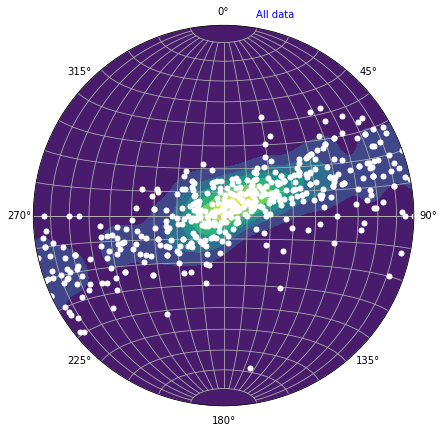

----------------------------------------------------------------------------------------------------------------------
MISSISSIPPIAN observations has no observations
----------------------------------------------------------------------------------------------------------------------
UPPER DEVONIAN observations has no observations
----------------------------------------------------------------------------------------------------------------------
UPPER ORDOVICIAN observations has no observations
----------------------------------------------------------------------------------------------------------------------
MIDDLE ORDOVICIAN observations has no observations
----------------------------------------------------------------------------------------------------------------------
LOWER ORDOVICIAN observations has no observations
----------------------------------------------------------------------------------------------------------------------
UPPER CAMBRIAN observations has no obser

In [31]:
geology = gpd.read_file(geology_file,bbox=bbox)

geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)

orientations = gpd.read_file(structure_file,bbox=bbox)
if(len(orientations)<2):
    raise NameError('Not enough orientations to complete calculations (need at least 2)')
group_girdle=m2l_utils.plot_bedding_stereonets(orientations,geology,c_l)


## Test code to automatically create super_groups and use_group3

In [32]:
misorientation=30
super_groups,use_gcode3=m2l_topology.super_groups_and_groups(group_girdle,tmp_path,misorientation)


,plunge,bearing,num orientations
MISSISSIPPIAN,-999,-999,0
UPPER DEVONIAN,-999,-999,0
UPPER ORDOVICIAN,-999,-999,0
MIDDLE ORDOVICIAN,-999,-999,0
LOWER ORDOVICIAN,-999,-999,0
UPPER CAMBRIAN,-999,-999,0


## Decide on super groups and groups
Supergroups define what shall be interpolated as single system   
use_gcode defines which groups we choose to calculate model from  

<font color='red'>The following outputs are the default settings that put all groups as one super_group for orientation interpolation purposes and use_gcode3 defines which groups will actually be modelled If after looking at the stereonets you want to change these defaults, just copy paste the two following lines into the next cell below and edit them as you wish. </font>  

In [33]:

print("super_groups=",super_groups)
print("use_gcode3=",use_gcode3)


super_groups= [['MISSISSIPPIAN', 'UPPER DEVONIAN', 'UPPER ORDOVICIAN', 'MIDDLE ORDOVICIAN', 'LOWER ORDOVICIAN', 'UPPER CAMBRIAN']]
use_gcode3= ['MISSISSIPPIAN', 'UPPER_DEVONIAN', 'UPPER_ORDOVICIAN', 'MIDDLE_ORDOVICIAN', 'LOWER_ORDOVICIAN', 'UPPER_CAMBRIAN']


## Preprocess data to ensure it meets modelling requirements

In [34]:
print('only processing',use_gcode3)

inputs=('')

if(workflow['model_engine'] =='geomodeller'):
    inputs=('invented_orientations','intrusive_orientations','fat_orientations','near_fault_orientations','fault_tip_contacts','contact_orientations')
elif(workflow['model_engine']=='loopstructural'):
    inputs=('invented_orientations','fat_orientations','contact_orientations','intrusive_orientations')
elif(workflow['model_engine']=='gempy'):
    inputs=('invented_orientations','interpolated_orientations','fat_orientations')
elif(workflow['model_engine']=='noddy'):
    inputs=('')

only processing ['MISSISSIPPIAN', 'UPPER_DEVONIAN', 'UPPER_ORDOVICIAN', 'MIDDLE_ORDOVICIAN', 'LOWER_ORDOVICIAN', 'UPPER_CAMBRIAN']


## Plot geology polygons and bounding box

../Rockies/tmp/geol_clip.shp


,RM_AGE,OBJECTID,MAP_THEME,FEATURE,MAP_UNIT,PARENTS,MAX_AGE,MIN_AGE,LITH_LIST,GENESIS,LABEL,REFERENCE,MAP_ID,STYLE_ID,SYMBOL,Anno,Shape_Le_1,Shape_Area,RM_AGE2,geometry
0,753,92,"bedrock, at surface",map unit,"Banff Formation, Upper unit; Bourgeau facies",Bourgeau facies,MISSISSIPPIAN,MISSISSIPPIAN,"wackestone, packstone, dolostone, chert, grain...",Shelf Sedimentation,Cb-Bf-u-B,"McMechan, M.E., 2011, CGM 13",82J/13,00760_Cb-Bf-l-u_993,None,None,12174.682909,4.178960e+06,2247,"POLYGON ((605208.072 5633404.715, 605208.011 5..."
1,756,70,"bedrock, at surface",map unit,"Banff Formation, Lower unit, upper part; Bourg...",Bourgeau facies,MISSISSIPPIAN,MISSISSIPPIAN,"shale, carbonate, chert, siltstone",Shelf Sedimentation,Cb-Bf-l-u,"McMechan, M.E., 2011, CGM 13",82J/13,00760_Cb-Bf-l-u_993,None,None,4398.576830,2.873621e+05,2244,"MULTIPOLYGON (((605441.182 5632886.214, 605428..."
2,760,64,"bedrock, at surface",map unit,"Exshaw and Banff (lower unit, lower and middle...",Bourgeau facies,UPPER DEVONIAN,MISSISSIPPIAN,"shale, chert, siltstone, wackestone, spiculite...",Shelf Sedimentation,DvCb-EBf-l-lm,"McMechan, M.E., 2011, CGM 13",82J/13,00760_Cb-Bf-l-u_993,None,None,3417.357852,1.308884e+05,2240,"MULTIPOLYGON (((605626.350 5632474.350, 605615..."
3,880,79,"bedrock, at surface",map unit,Palliser Formation,Upper Devonian,UPPER DEVONIAN,UPPER DEVONIAN,"limestone, dolostone, chert",Shelf Sedimentation,Dv-Pa,"McMechan, M.E., 2011, CGM 13",82J/13,00880_Dv-Pa_612,None,None,6438.534531,2.322293e+06,2120,"MULTIPOLYGON (((602872.859 5637104.359, 602872..."
4,1030,83,"bedrock, at surface",map unit,Sassenach Formation,Upper Devonian,UPPER DEVONIAN,UPPER DEVONIAN,"siltstone, sandstone, shale, limestone",Shelf Sedimentation,Dv-Ss,"McMechan, M.E., 2011, CGM 13",82J/13,01050_Dv-M_724,None,None,10601.587944,7.113647e+05,1970,"POLYGON ((602707.181 5636433.594, 602705.246 5..."


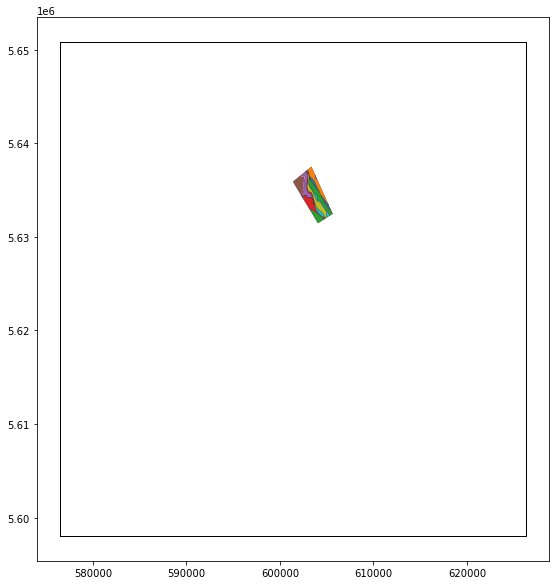

In [35]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

geology_ll[c_l['g']].fillna(geology_ll[c_l['g2']], inplace=True)
geology_ll[c_l['g']].fillna(geology_ll[c_l['c']], inplace=True)
display(geology_ll.head())
base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


In [36]:
c_l

{'d': 'DIP',
 'dd': 'STRIKE',
 'sf': 'SUBFEATURE',
 'bedding': 'bed',
 'otype': 'strike',
 'bo': 'ATTITUDE',
 'btype': 'over',
 'g': 'MAX_AGE',
 'g2': 'MIN_AGE',
 'c': 'LABEL',
 'ds': 'LITH_LIST',
 'u': 'MAP_THEME',
 'r1': 'LITH_LIST',
 'r2': 'GENESIS',
 'sill': 'sill',
 'intrusive': 'intrusive',
 'volcanic': 'volc',
 'msc': 'SITE_CODE',
 'msn': 'SHORT_NAME',
 'mst': 'SITE_TYPE_',
 'mtc': 'TARGET_COM',
 'mscm': 'SITE_COMMO',
 'mcom': 'COMMODITY_',
 'minf': 'Cons',
 'min': 'RM_AGE',
 'max': 'RM_AGE',
 'f': 'FEATURE',
 'fault': 'fault',
 'ff': 'FEATURE',
 'fold': 'Fold',
 'fdip': 'ATTITUDE',
 'fdipnull': '0',
 'fdipdir': 'CONFIDENCE',
 'fdipdir_flag': 'alpha',
 'fdipest': 'OBJECTID',
 'fdipest_vals': 'MOVEMENT',
 'n': 'NAME',
 't': 'SUBFEATURE',
 'syn': 'syn',
 'o': 'OBJECTID',
 'gi': 'STATION_ID'}

## Save geology to file as WKT

In [37]:
hint_flag=False # use GSWA strat database to provide relative age hints
def unique_list(list1): 
      
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    return(list(list_set)) 
list1=['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]
list2=unique_list(list1)

sub_geol = geology_ll[list2]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l,hint_flag)

11  polygons


## Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

0  points


C:\Users\00073294\Anaconda3\envs\loop\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


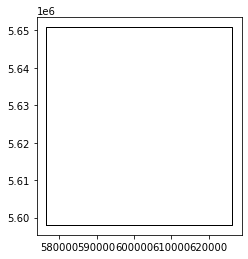

In [38]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Read and save orientations data point data as WKT

464  points


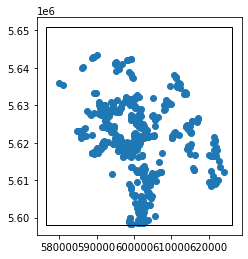

In [39]:
orientations = gpd.read_file(structure_file,bbox=bbox)

sub_pts = orientations[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

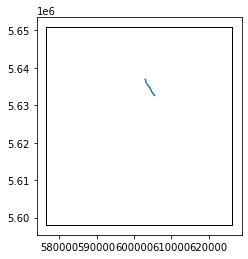

In [40]:
#tempcode=c_l['o'] # fudge********************************
#c_l['o']='NAME' # fudge********************************
if(os.path.exists(fault_file)):
    lines_ll=gpd.read_file(fault_file,bbox=bbox)

    sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
    base=sub_lines.plot()
    polygon.plot(ax=base, color='none',edgecolor='black')
else:
    sub_lines=[]


## Save faults to file as WKT

In [41]:
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)
#c_l['o']=tempcode # fudge********************************


4  polylines


## Create map2model input file

In [42]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,mindep_file_csv,minx,maxx,miny,maxy,500.0,'Fe,Cu,Au,NONE',2)


## Calculate topology

In [43]:
import subprocess
import platform
os.chdir(m2m_cpp_path)
print(os.getcwd())
#%system map2model.exe Parfile
if(platform.system()=='Windows'):
    subprocess.run(["map2model.exe", "Parfile"])
else:
    subprocess.run(["./map2model", "Parfile"])

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


## Simple network graph of the geology with legend   
If in Australia we can use data derived from the ASUD database to refine stratigraphic relationships

In [44]:
if(Australia):
    asud_strat_file='../source_data/ASUD.csv'
    m2l_topology.use_asud(strat_graph_file, asud_strat_file,graph_path)
    strat_graph_file=graph_path+'ASUD_strat.gml'



0    'Cb-Bf-u-B'
1    'Cb-Bf-l-u'
2    'DvCb-EBf-l-lm'
3    'Dv-Pa'
4    'Dv-Ss'
5    'Dv-PMH'
6    'Dv-A'
7    'OdSl-B'
8    'Od-Sk'
9    'Od-Tp'
10    'CmOd-SP'


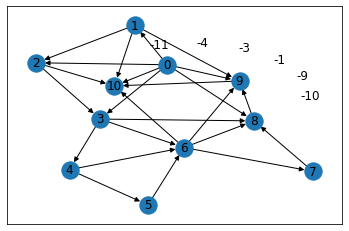

In [45]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>




In [46]:
os.chdir('../map2loop')

print(os.getcwd())

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Next we define an area of interest and some other basic stuff

In [47]:
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

In [48]:
from urllib.request import urlopen

def get_dtm_topography_org(path_out, minlong,maxlong,minlat,maxlat):

    link='https://portal.opentopography.org/otr/getdem?demtype=SRTMGL3&west='+str(minlong)+'&south='+str(minlat)+'&east='+str(maxlong)+'&north='+str(maxlat)+'&outputFormat=GTiff'

    print(link)
    img = urlopen(link)
   
    f = open(path_out, 'wb')
    f.write(img.read())
    f.close()
    print("dtm geotif saved as",path_out)

-115.96604120090015 -115.15503738971087 50.47547240934318 51.049125500685236
Attempt: 0 https://portal.opentopography.org/otr/getdem?demtype=SRTMGL3&west=-115.96604120090015&south=50.47547240934318&east=-115.15503738971087&north=51.049125500685236&outputFormat=GTiff
dtm geotif saved as ../Rockies/dtm/dtm.tif

reprojected dtm geotif saved as ../Rockies/dtm/dtm_rp.tif


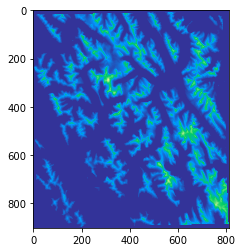

In [49]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
downloaded = False
i=0
print('Attempt: 0 ',end='')
while downloaded == False:
    try:
        #m2l_utils.get_dtm_hawaii(dtm_file, minlong,maxlong,minlat,maxlat)
        get_dtm_topography_org(dtm_file, minlong,maxlong,minlat,maxlat)
        downloaded=True
    except:
        time.sleep(10)
        i=i+1
        print(' ',i,end='')
if(i==100):
    raise NameError('map2loop error: Could not access DTM server after 100 attempts')
print()

geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)

dtm = rasterio.open(dtm_reproj_file)
pyplot.imshow(dtm.read(1), cmap='terrain',vmin=2000,vmax=5000)
pyplot.show()



## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

In [50]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
display(groups,glabels)

6

{-10: 'LOWER_ORDOVICIAN',
 -9: 'MIDDLE_ORDOVICIAN',
 -1: 'MISSISSIPPIAN',
 -3: 'UPPER_CAMBRIAN',
 -4: 'UPPER_DEVONIAN',
 -11: 'UPPER_ORDOVICIAN'}

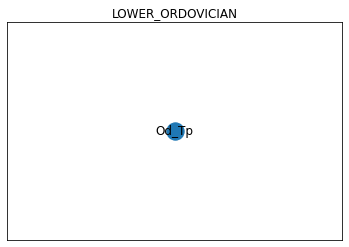

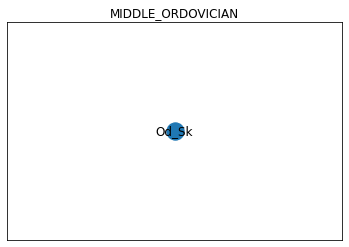

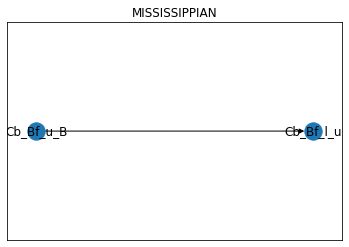

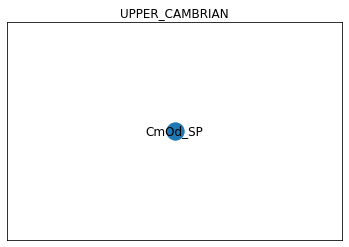

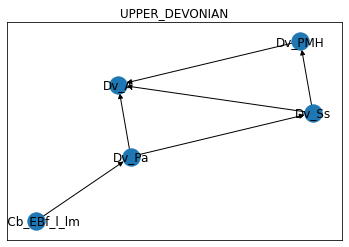

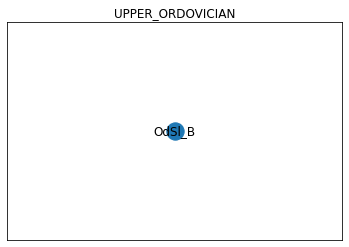

In [51]:
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import functools 
import operator  
import shapely.affinity
from shapely.ops import split
from shapely.geometry import Point, LineString, MultiLineString, GeometryCollection, Polygon
from math import degrees,atan2, acos, degrees
import warnings

from map2loop import m2l_utils

def save_units(G,path_out,glabels,Australia,asud_strat_file):
    if Australia:
        ASUD=pd.read_csv(asud_strat_file,',') 
    for p in glabels: #process each group, removing nodes that are not part of that group, and other groups
        GD=G.copy() #temporary copy of full graph
        #print()
        #print(p,glabels[p].replace(" ","_").replace("-","_"))
        nlist=list(G.nodes)

        for n in nlist: # Calculate total number of groups and their names groups
            if('gid' in GD.nodes[n]): #normal node
                if(GD.nodes[n]['gid']!=p): #normal node but not part of current group
                    GD.remove_node(n)
            else:                     #group node
                GD.remove_node(n)
        
        labels = {}
        for node in GD.nodes():   #local store of node labels     
            labels[node] = G.nodes[node]['LabelGraphics']['text'].replace(" ","_").replace("-","_")

        cycles=nx.simple_cycles(GD)
        #for cy in cycles:
            #print(cy[0],cy[1])

        for cy in cycles:
            found=False
            #print("go",cy[0],cy[1])

            if Australia:
                len_cy=len(cy)
                for i in range(len_cy-1):
                    glabel_0=GD.nodes[cy[i]]['LabelGraphics']['text']
                    glabel_1=GD.nodes[cy[i+1]]['LabelGraphics']['text']
                    edge=ASUD.loc[(ASUD['over'] == glabel_0) & (ASUD['under'] == glabel_1) ]
                    if(len(edge)==0 and (not('isGroup' in GD.nodes[cy[i]]) and not('isGroup' in GD.nodes[cy[i+1]]))):
                        
                        #  is this  right?????
                        if(GD.has_edge(cy[i],cy[i+1])):  
                            continue
                        else:
                            warning_msg='map2loop warning 1: Stratigraphic relationship: '+ str(GD.nodes[cy[i]]['LabelGraphics']['text'])+' overlies '+str(GD.nodes[cy[i+1]]['LabelGraphics']['text'])+' removed to prevent cycle'      
                            warnings.warn(warning_msg)
                            GD.remove_edge(cy[i],cy[i+1])
                            found=True

                            
                if(not found):
                    glabel_0=GD.nodes[cy[len_cy-1]]['LabelGraphics']['text']
                    glabel_1=GD.nodes[cy[0]]['LabelGraphics']['text']
                    edge=ASUD.loc[(ASUD['over'] == glabel_0) & (ASUD['under'] == glabel_1) ]
                    if(len(edge)==0 and (not('isGroup' in GD.nodes[cy[len_cy-1]]) and not('isGroup' in GD.nodes[cy[0]]))):
                        if( GD.has_edge(cy[len_cy-1],cy[0])):
                            warning_msg='map2loop warning 1: Stratigraphic relationship: '+ str(GD.nodes[cy[len_cy-1]]['LabelGraphics']['text'])+' overlies '+str(GD.nodes[cy[0]]['LabelGraphics']['text'])+' removed to prevent cycle'      
                            warnings.warn(warning_msg)
                            GD.remove_edge(cy[len_cy-1],cy[0])
                            found=True
                    if(not found):
                        if(GD.has_edge(cy[0],cy[1])):
                            warning_msg='map2loop warning 2: Stratigraphic relationship: '+ str(GD.nodes[cy[0]]['LabelGraphics']['text'])+' overlies '+str(GD.nodes[cy[1]]['LabelGraphics']['text'])+' removed to prevent cycle'      
                            warnings.warn(warning_msg)
                            GD.remove_edge(cy[0],cy[1])
                   
            else:
                if(GD.has_edge(cy[0],cy[1])):
                    warning_msg='map2loop warning 3: Stratigraphic relationship: '+ str(GD.nodes[cy[0]]['LabelGraphics']['text'])+' overlies '+str(GD.nodes[cy[1]]['LabelGraphics']['text'])+' removed to prevent cycle'      
                    warnings.warn(warning_msg)
                    GD.remove_edge(cy[0],cy[1])
        
        plt.figure(p+1) #display strat graph for one group
        plt.title(glabels[p])
        nx.draw_networkx(GD, pos=nx.kamada_kawai_layout(GD), arrows=True,with_labels=False)
        nx.draw_networkx_labels(GD,pos=nx.kamada_kawai_layout(GD), labels=labels, font_size=12,font_family='sans-serif')
        
        #cycles=nx.simple_cycles(GD)
        #for cy in cycles:
            #print(cy[0],cy[1])

        one=True
        if(one):
            nlist=list(nx.topological_sort(GD)) #one possible sorted directional graphs
        else:
            nlist=list(nx.all_topological_sorts(GD)) #all possible sorted directional graphs
            
        
        f = open(path_out+"/"+glabels[p].replace(" ","_").replace("-","_")+'.csv', 'w')

        if(one):
                f.write('Choice '+str(0))
                for n in range(0,len(GD)): #display nodes for one sorted graph
                   
                    f.write(","+G.nodes[nlist[n]]['LabelGraphics']['text'].replace(" ","_").replace("-","_"))
                
                f.write('\n')
        else:
            for m in range(10): #process first ten sorted graphs
                f.write('Choice '+str(m))
                for n in range(0,len(GD)): #display nodes for one sorted graph
                    #print(nlist[m][n],G.nodes[nlist[m][n]]['LabelGraphics']['text'].replace(" ","_").replace("-","_"))
                    f.write(","+G.nodes[nlist[m][n]]['LabelGraphics']['text'].replace(" ","_").replace("-","_"))
                #if(m<len(nlist)-1):
                    #print("....")
                f.write('\n')
        f.close()
save_units(G,tmp_path,glabels,Australia,asud_strat_file)

In [52]:
#m2l_topology.save_units(G,tmp_path,glabels,Australia,asud_strat_file)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

../Rockies/tmp/faults_clip.shp


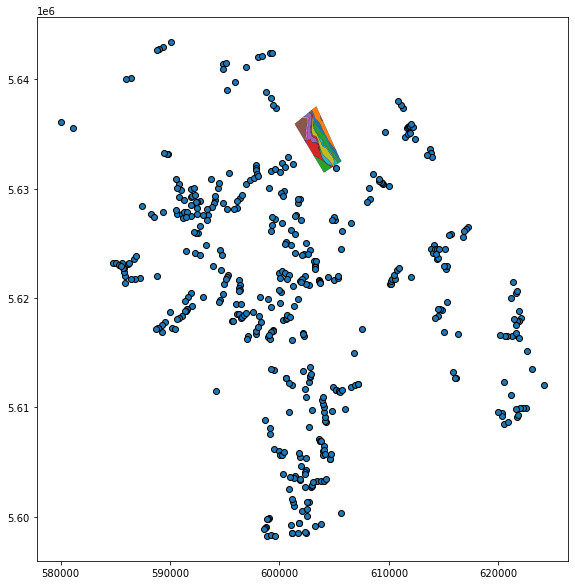

In [53]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)
geology[c_l['g']].fillna(geology[c_l['g2']], inplace=True)
geology[c_l['g']].fillna(geology[c_l['c']], inplace=True)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
if(os.path.exists(fault_file)):
    faults_clip = gpd.read_file(fault_file,bbox=bbox)
    faults_clip.crs=dst_crs

list1=['geometry',c_l['d'],c_l['dd'],c_l['sf'],c_l['bo']]
list2=unique_list(list1)
       
sub_pts = structure[list2] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults_clip.plot(ax=base, column=c_l['f'],edgecolor='black')

## Join geology and structures, save fold axial traces

In [54]:
geol_clip = m2l_utils.explode(geology)
geol_clip.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geol_clip, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
structure_clip = structure_code[is_bed]
structure_clip.crs = dst_crs


if(c_l['dd']=='strike'):
    structure_clip['azimuth2'] = structure_clip.apply(lambda row: row[c_l['dd']]+90.0, axis = 1)
    c_l['dd']='azimuth2'
    

structure_clip.to_file(tmp_path+'structure_clip.shp')


## Create possible stratigraphy sets per group
mj: <font color='red'>Uses first of each possible set of toplogies per unit and per group, which is arbitrary. </font>On the other hand we are not checking relative ages again to see if this helps reduce ambiguity, which I think it would.

,index,min,max,ave
group_,,,,
MISSISSIPPIAN,0,753.0,756.0,754.5
UPPER_DEVONIAN,1,760.0,1050.0,905.0
UPPER_ORDOVICIAN,2,1400.0,1400.0,1400.0
MIDDLE_ORDOVICIAN,3,1420.0,1420.0,1420.0
LOWER_ORDOVICIAN,4,1450.0,1450.0,1450.0
UPPER_CAMBRIAN,5,1610.0,1610.0,1610.0


[]

{-10: 'LOWER_ORDOVICIAN',
 -9: 'MIDDLE_ORDOVICIAN',
 -1: 'MISSISSIPPIAN',
 -3: 'UPPER_CAMBRIAN',
 -4: 'UPPER_DEVONIAN',
 -11: 'UPPER_ORDOVICIAN'}

group choices: 1


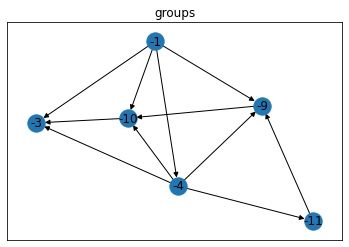

In [55]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Calculate cover depth grid and contacts    
Grid is assumed to be of depth below surface   

Also need to cater for case when we only have grid, no shapefile, so need to add a fake horizontal orientation in the middle of the map at average depth.

In [56]:
if(workflow['cover_map']):

    dtm = rasterio.open(dtm_reproj_file)
    dtb_raw = rasterio.open(dtb_grid)

    cover=gpd.read_file(cover_map_path)

    with fiona.open(cover_map_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(dtb_grid) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(dtb_clip, "w", **out_meta) as dest:
        dest.write(out_image)  

    dtb = rasterio.open(dtb_clip)
    
    m2l_geometry.process_cover(output_path,dtm,dtb,dtb_null,cover,workflow['cover_map'],cover_dip,bbox,dst_crs,cover_spacing,contact_decimate=3,use_vector=True,use_grid=True)    
    
    super_groups.append('cover')

## Export orientation data in csv  format


0 orientations saved to ../Rockies/output/orientations.csv


C:\Users\00073294\Anaconda3\envs\loop\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


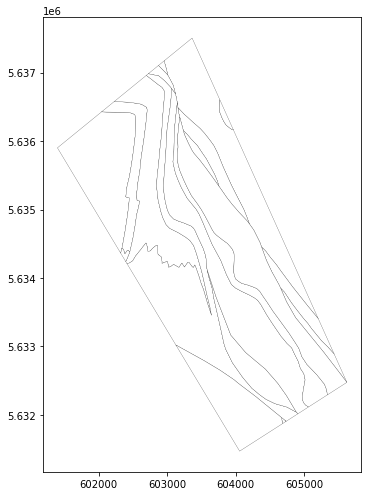

In [57]:
m2l_geometry.save_orientations(structure_clip,output_path,c_l,orientation_decimate,dtm,dtb,dtb_null,workflow['cover_map'])

m2l_utils.plot_points(output_path+'orientations.csv',geol_clip, 'formation','X','Y',True,'alpha')

## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [58]:
#m2l_geometry.create_orientations( tmp_path, output_path, dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,structure_clip,c_l)

## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [59]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],geol_clip,contact_decimate,c_l,intrusion_mode)

basal contacts saved allpts= 2420 deci_pts= 179
saved as ../Rockies/tmp/all_contacts.csv and ../Rockies/tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [60]:
from shapely import geometry
from shapely.geometry import shape, Polygon, LineString, Point, MultiLineString, MultiPolygon
import matplotlib.pyplot as plt
import requests
import rasterio
from pandas import DataFrame
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
from math import acos, sqrt, cos, sin, degrees, radians, fabs, atan2, fmod, isnan
from map2loop import m2l_utils
from map2loop import m2l_interpolation
import numpy as np
import os
import random

def save_basal_no_faults(path_out,path_fault,ls_dict,dist_buffer,c_l,dst_crs):
    
    if(os.path.exists(path_fault)):
        faults_clip_all = gpd.read_file(path_fault)
        faults_clip=faults_clip_all[faults_clip_all[c_l['f']].str.contains(c_l['fault'])]
        df = DataFrame.from_dict(ls_dict, "index")
        contacts = GeoDataFrame(df,crs=dst_crs, geometry='geometry')


        fault_zone = faults_clip.buffer(dist_buffer) #defines buffer around faults where strat nodes will be removed
        fault_zone=fault_zone[~fault_zone.isna()]  # checks for empty fault strings???
        #display(fault_zone)
        all_fz = fault_zone.unary_union

        contacts_nofaults = contacts.difference(all_fz) #deletes contact nodes within buffer
    
    
        
        ls_nf={}
    
        cnf_copy=contacts_nofaults.copy()
    
        #print(contacts_nofaults.shape)
        for i in range(0,len(contacts_nofaults)): 
            j=len(contacts_nofaults)-i-1
            #print(j)
            if(cnf_copy.iloc[j].geom_type=="GeometryCollection"):#remove rows with geometry collections (== empty?)
                cnf_copy.drop([j,j],inplace=True)
            else: # save to dataframe
                ls_nf[j]= {"id": j,c_l['c']:df.iloc[j][c_l['c']].replace(" ","_").replace("-","_"),c_l['g']:df.iloc[j][c_l['g']].replace(" ","_").replace("-","_"), "geometry": cnf_copy.iloc[j]}
    
    
    
        df_nf = DataFrame.from_dict(ls_nf, "index")
    
        contacts_nf = GeoDataFrame(df_nf,crs=dst_crs, geometry='geometry')
        contacts_nf.to_file(driver = 'ESRI Shapefile', filename= path_out)
    
        #contacts_nofaults = gpd.read_file('./data/faults_clip.shp')
        print("basal contacts without faults saved as",path_out)
    else:
        df = DataFrame.from_dict(ls_dict, "index")                   
        contacts = GeoDataFrame(df,crs=dst_crs, geometry='geometry') 
        contacts.to_file(driver = 'ESRI Shapefile', filename= path_out)        
        print("basal contacts without faults saved as",path_out)
save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

basal contacts without faults saved as ../Rockies/tmp/basal_contacts.shp


In [61]:
#m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

## Remove faults from decimated basal contacts as save as csv file

decimated contacts saved as ../Rockies/output/contacts4.csv


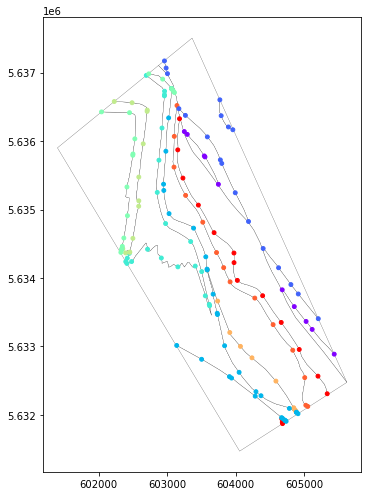

In [62]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,dtb,dtb_null,workflow['cover_map'],contact_decimate,c_l)

m2l_utils.plot_points(output_path+'contacts4.csv',geol_clip, 'formation','X','Y',False,'alpha')


## Orientation and contact interpolation
Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for populating parts of maps where little structural data is available

In [63]:
basal_contacts=tmp_path+'basal_contacts.shp'

orientation_interp,contact_interp,combo_interp=m2l_interpolation.interpolation_grids(geology_file,structure_file,basal_contacts,bbox,spacing,dst_crs,scheme,super_groups,c_l)


f=open(tmp_path+'interpolated_orientations.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in orientation_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_contacts.csv','w')
f.write('X,Y,l,m,angle\n')
for row in contact_interp:
    ostr='{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4])
    f.write(ostr)
f.close()
f=open(tmp_path+'interpolated_combined.csv','w')
f.write('X,Y,l,m,n,dip,dip_dir\n')
for row in combo_interp:
    ostr='{},{},{},{},{},{},{}\n'.format(row[0],row[1],row[2],row[3],row[4],row[5],row[6])
    f.write(ostr)
f.close()

['MISSISSIPPIAN', 'UPPER DEVONIAN', 'UPPER ORDOVICIAN', 'MIDDLE ORDOVICIAN', 'LOWER ORDOVICIAN', 'UPPER CAMBRIAN'] has no structures


C:\Users\00073294\AppData\Roaming\Python\Python37\site-packages\map2loop-0.0.50-py3.7.egg\map2loop\m2l_interpolation.py:1481: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\00073294\AppData\Roaming\Python\Python37\site-packages\map2loop-0.0.50-py3.7.egg\map2loop\m2l_interpolation.py:1482: RuntimeWarning: divide by zero encountered in true_divide


100 106
interpolated dips


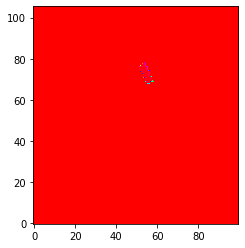

In [64]:
if(spacing<0):
    spacing=-(bbox[2]-bbox[0])/spacing
x=int((bbox[2]-bbox[0])/spacing)+1
y=int((bbox[3]-bbox[1])/spacing)+1
print(x,y)
dip_grid=np.ones((y,x))
dip_grid=dip_grid*-999
dip_dir_grid=np.ones((y,x))
dip_dir_grid=dip_dir_grid*-999
contact_grid=np.ones((y,x))
contact_grid=dip_dir_grid*-999
for row in combo_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    dip_grid[r,c]=float(row[5])
    dip_dir_grid[r,c]=float(row[6])

for row in contact_interp:
    r=int((row[1]-bbox[1])/spacing)
    c=int((row[0]-bbox[0])/spacing)
    contact_grid[r,c]=float(row[4])

print('interpolated dips')
plt.imshow(dip_grid, cmap="hsv",origin='lower',vmin=-90,vmax=90)  
plt.show()

interpolated dip directions


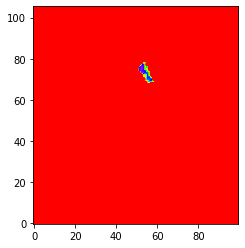

In [65]:
print('interpolated dip directions')
       
plt.imshow(dip_dir_grid, cmap="hsv",origin='lower',vmin=0,vmax=360)    
plt.show()

interpolated contacts


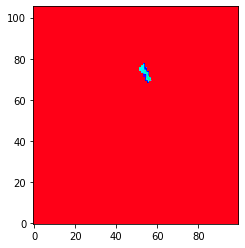

In [66]:
print('interpolated contacts')
       
plt.imshow(contact_grid, cmap="hsv",origin='lower',vmin=-360,vmax=360)    
plt.show()

## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

In [67]:
from shapely import geometry
from shapely.geometry import shape, Polygon, LineString, Point, MultiLineString, MultiPolygon
import matplotlib.pyplot as plt
import requests
import rasterio
from pandas import DataFrame
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
from math import acos, sqrt, cos, sin, degrees, radians, fabs, atan2, fmod, isnan
from map2loop import m2l_utils
from map2loop import m2l_interpolation
import numpy as np
import os
import random

def save_faults(path_faults,output_path,dtm,dtb,dtb_null,cover_map,c_l,fault_decimate,fault_min_len,fault_dip):
    f=open(output_path+'/faults.csv',"w")
    f.write("X,Y,Z,formation\n")
    fo=open(output_path+'/fault_orientations.csv',"w")
    fo.write("X,Y,Z,DipDirection,dip,DipPolarity,formation\n")
    #fo.write("X,Y,Z,azimuth,dip,polarity,formation\n")
    fd=open(output_path+'/fault_dimensions.csv',"w")
    fd.write("Fault,HorizontalRadius,VerticalRadius,InfluenceDistance\n")
    #fd.write("Fault_ID,strike,dip_direction,down_dip\n")
    if(os.path.exists(path_faults)):
        faults_clip=gpd.read_file(path_faults)
            
        split=c_l['fdipest_vals'].split(",") #convert text dips to equally spaced angles
        fault_dip_choices=np.linspace(0,90, len(split)+1)
        dip_dirs={'north':(0.0,1.0),'northeast':(.707,.707),'east':(1.0,0.0),'southeast':(.707,-.707),
                  'south':(0.0,-1.0),'southwest':(-.707,-.707),'west':(-1.0,0.0),'northwest':(-.707,.707),
                  'North':(0.0,1.0),'Northeast':(.707,.707),'East':(1.0,0.0),'Southeast':(.707,-.707),
                  'South':(0.0,-1.0),'Southwest':(-.707,-.707),'West':(-1.0,0.0),'Northwest':(-.707,.707),
                  'Unknown':(0.0,1.0),'Vertical':(.707,.707)}
        
        
        for indx,flt in faults_clip.iterrows():
            if(c_l['fault'] in flt[c_l['f']]):
                #fault_name='Fault_'+str(flt[c_l['o']])
                fault_name=flt[c_l['n']]    #need to have flag for using objectid or name???
                if(not str(flt.geometry)=='None'):
                    if(flt.geometry.type=='LineString'):
                        flt_ls=LineString(flt.geometry)
                        dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                        dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]

                        strike=sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        if(strike>fault_min_len):
                            i=0
                            saved=0
                            for afs in flt_ls.coords:
                                if(m2l_utils.mod_safe(i,fault_decimate)==0 or i==int((len(flt_ls.coords)-1)/2) or i==len(flt_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape                         
                                    if(saved==0):
                                        p1x=afs[0]
                                        p1y=afs[1]
                                    elif(saved==1):
                                        p2x=afs[0]
                                        p2y=afs[1]
                                    elif(saved==2):
                                        p3x=afs[0]
                                        p3y=afs[1]
                                        # avoids narrow angles in fault traces which geomodeller refuses to solve
                                        # should really split fault in two at apex, but life is too short
                                        if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0): 
                                            break
                                    elif(saved>2):
                                        p1x=p2x
                                        p1y=p2y
                                        p2x=p3x
                                        p2y=p3y
                                        p3x=afs[0]
                                        p3y=afs[1]
                                        # avoids narrow angles in fault traces which geomodeller refuses to solve
                                        # should really split fault in two at apex, but life is too short
                                        if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0):
                                            break 
                                    saved=saved+1
                                    locations=[(afs[0],afs[1])]     
                                    height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                    # slightly randomise first and last points to avoid awkward quadruple junctions etc.
                                    #if(i==0 or i==len(flt_ls.coords)-1):
                                    #    ostr=str(afs[0]+np.random.ranf())+","+str(afs[1]+np.random.ranf())+","+str(height)+","+fault_name+"\n"
                                    #else:
                                    ostr="{},{},{},{}\n"\
                                         .format(afs[0],afs[1],height,fault_name)
                                    #ostr=str(afs[0])+","+str(afs[1])+","+str(height)+","+fault_name+"\n"                            
                                    f.write(ostr)                
                                i=i+1  
                            if(dlsx==0.0 or dlsy == 0.0):
                                continue
                            lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                            lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))        
                            azimuth=degrees(atan2(lsy,-lsx)) % 180 #normal to line segment           
                            locations=[(flt_ls.coords[int((len(afs)-1)/2)][0],flt_ls.coords[int((len(afs)-1)/2)][1])]     
                            height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)

                            if(flt[c_l['o']]=='-1'):
                                print(flt[c_l['o']],c_l['fdip'],flt[c_l['fdip']],c_l['fdipnull'],c_l['fdipest'],
                                  flt[c_l['fdipest']],c_l['fdipest_vals'])

                            if(flt[c_l['fdip']]==c_l['fdipnull']): # null specifc dip defined
                                if(not str(flt[c_l['fdipest']])=='None'): #  dip estimate defined
                                    i=0
                                    for choice in split:
                                        if(flt[c_l['o']]=='-1'):
                                            print(choice)
                                        if(choice == flt[c_l['fdipest']]):
                                            fault_dip=int(fault_dip_choices[i+1])
                                            if(flt[c_l['o']]=='-1'):
                                                print('found_dip',fault_dip)
                                        i=i+1
                                else:
                                    if(fault_dip == -999): # random flag
                                        fault_dip=random.randint(60,90)
                            else:
                                fault_dip=int(flt[c_l['fdip']]) # specific dip defined

                            if(c_l['fdipdir_flag']=='num'): # numeric dip direction defined
                                azimuth=flt[c_l['fdipdir']]
                            elif(not str(flt[c_l['fdipdir']])=='None' and not flt[c_l['fdip']]== c_l['fdipnull'] ): # alpha dip direction defined
                                dotprod=degrees(acos((-lsx*dip_dirs[flt[c_l['fdipdir']]][0])+(lsy*dip_dirs[flt[c_l['fdipdir']]][1])))
                                if(dotprod>45):
                                    fault_dip=-fault_dip


                            ostr="{},{},{},{},{},{},{}\n"\
                                 .format(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0],flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1],
                                         height,azimuth,fault_dip,1,fault_name)
                            #ostr=str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0])+","+str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1])+","+height+","+str(azimuth)+","+str(fault_dip)+",1,"+fault_name+"\n"
                            fo.write(ostr)
                            strike=strike*1.25
                            ostr="{},{},{},{}\n"\
                                 .format(fault_name,strike/2,strike,strike/4.0)
                            #ostr=fault_name+","+str(strike/2)+","+str(strike)+","+str(strike/4.0)+"\n"
                            fd.write(ostr)
                    elif(flt.geometry.type=='MultiLineString' or flt.geometry.type=='GeometryCollection' ): #shouldn't happen any more
                        sum_strike=0
                        first=True
                        for pline in flt.geometry:
                            flt_ls=LineString(pline)
                            dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                            dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]
                            sum_strike=sum_strike+sqrt((dlsx*dlsx)+(dlsy*dlsy))  
                            if(first):
                                firstx=flt_ls.coords[0][0]
                                firsty=flt_ls.coords[0][1]
                            lastx=flt_ls.coords[0][0]
                            lasty=flt_ls.coords[0][1]
                        ostr="{},{},{},{}\n"\
                                 .format(fault_name,sum_strike/2,sum_strike,sum_strike/4.0)    
                        #ostr=fault_name+","+str(sum_strike/2)+","+str(sum_strike)+","+str(sum_strike/4.0)+"\n"
                        fd.write(ostr) 

                        dlsx=firstx-lastx
                        dlsy=firsty-lasty
                        if(dlsx==0.0 or dlsy == 0.0):
                                continue            

                        lsx=dlsx/sqrt((dlsx*dlsx)+(dlsy*dlsy))
                        lsy=dlsy/sqrt((dlsx*dlsx)+(dlsy*dlsy))        
                        azimuth=degrees(atan2(lsy,-lsx)) % 180 #normal to line segment           
                        locations=[(flt_ls.coords[int((len(afs)-1)/2)][0],flt_ls.coords[int((len(afs)-1)/2)][1])]     # should be mid-fault not mid fault segemnt but probs doesnt matter
                        height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                        ostr="{},{},{},{},{},{},{},\n"\
                                 .format(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0],flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1],height,azimuth,fault_dip,1,fault_name)
                        #ostr=str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][0])+","+str(flt_ls.coords[int((len(flt_ls.coords)-1)/2)][1])+","+height+","+str(azimuth)+","+str(fault_dip)+",1,"+fault_name+"\n"
                        fo.write(ostr)

                        for pline in flt.geometry:
                            #display(pline)
                            #display(flt)
                            flt_ls=LineString(pline)
                            dlsx=flt_ls.coords[0][0]-flt_ls.coords[len(flt_ls.coords)-1][0]
                            dlsy=flt_ls.coords[0][1]-flt_ls.coords[len(flt_ls.coords)-1][1]
                            if(dlsx==0.0 or dlsy == 0.0):
                                continue

                            if(sum_strike>fault_min_len):
                                i=0
                                saved=0
                                for afs in flt_ls.coords:
                                    if(m2l_utils.mod_safe(i,fault_decimate)==0 or i==int((len(flt_ls.coords)-1)/2) or i==len(flt_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape                         
                                        if(saved==0):
                                            p1x=afs[0]
                                            p1y=afs[1]
                                        elif(saved==1):
                                            p2x=afs[0]
                                            p2y=afs[1]
                                        elif(saved==2):
                                            p3x=afs[0]
                                            p3y=afs[1]
                                            # avoids narrow angles in fault traces which geomodeller refuses to solve
                                            # should really split fault in two at apex, but life is too short
                                            if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0): 
                                                break
                                        elif(saved>2):
                                            p1x=p2x
                                            p1y=p2y
                                            p2x=p3x
                                            p2y=p3y
                                            p3x=afs[0]
                                            p3y=afs[1]
                                            # avoids narrow angles in fault traces which geomodeller refuses to solve
                                            # should really split fault in two at apex, but life is too short
                                            if(m2l_utils.tri_angle(p2x,p2y,p1x,p1y,p3x,p3y)<45.0):
                                                break 
                                        saved=saved+1
                                        locations=[(afs[0],afs[1])]     
                                        height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                        # slightly randomise first and last points to avoid awkward quadruple junctions etc.
                                        #if(i==0 or i==len(flt_ls.coords)-1):
                                        #    ostr=str(afs[0]+np.random.ranf())+","+str(afs[1]+np.random.ranf())+","+str(height)+","+fault_name+"\n"
                                        #else:
                                        ostr="{},{},{},{}\n"\
                                             .format(afs[0],afs[1],height,fault_name)
                                        #ostr=str(afs[0])+","+str(afs[1])+","+str(height)+","+fault_name+"\n"                            
                                        f.write(ostr)                
                                    i=i+1  
    

    f.close()
    fo.close()
    fd.close()
    print("fault orientations saved as",output_path+'fault_orientations.csv')
    print("fault positions saved as",output_path+'faults.csv')
    print("fault dimensions saved as",output_path+'fault_dimensions.csv')

save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fault_decimate,min_fault_length,fault_dip)


fault orientations saved as ../Rockies/output/fault_orientations.csv
fault positions saved as ../Rockies/output/faults.csv
fault dimensions saved as ../Rockies/output/fault_dimensions.csv


In [68]:
#m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fault_decimate,min_fault_length,fault_dip)


In [69]:
import warnings
warnings.filterwarnings('ignore')

if(os.path.exists(fault_file)):
    faults=pd.read_csv(output_path+'faults.csv')
    faults_len=len(faults)

    if(faults_len>0):
        m2l_interpolation.process_fault_throw_and_near_faults_from_grid(tmp_path,output_path,dtm_reproj_file,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,bbox,
                                                                scheme,dip_grid,dip_dir_grid,x,y,spacing)


## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [70]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10

m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,dtb,dtb_null,workflow['cover_map'],pluton_form,pluton_dip,contact_decimate,c_l)



0 MISSISSIPPIAN
1 UPPER_DEVONIAN
2 UPPER_ORDOVICIAN
3 MIDDLE_ORDOVICIAN
4 LOWER_ORDOVICIAN
5 UPPER_CAMBRIAN
pluton contacts and orientations saved as:
../Rockies/output/ign_contacts.csv
../Rockies/output/ign_orientations_domes.csv


## Extract faults and basal contacts of groups from seismic section

In [71]:
if(workflow['seismic_section']):
    seismic_line_file=data_path+'seismic_line_10GA-CP1_rev.shp'   #input geology file (if local)
    seismic_line = gpd.read_file(seismic_line_file) #import map
    seismic_line.plot(figsize=(10,10),edgecolor='#000000',linewidth=0.2) #display map
    display(seismic_line)


    seismic_bbox_file=data_path+'seismic_bbox.shp'   #input geology file (if local)
    seismic_bbox = gpd.read_file(seismic_bbox_file) #import map
    seismic_bbox.set_index('POSITION',inplace=True)

    seismic_interp_file=data_path+'seismic_interp.shp'   #input geology file (if local)
    seismic_interp = gpd.read_file(seismic_interp_file) #import map
    seismic_interp.plot(column='FEATURE',figsize=(10,10),edgecolor='#000000',linewidth=0.5) #display map
    display(seismic_interp)

    surface_cut=2000

    m2l_geometry.extract_section(tmp_path,output_path,seismic_line,seismic_bbox,seismic_interp,dtm,dtb,dtb_null,workflow['cover_map'],surface_cut)

    contacts=pd.read_csv(output_path+'contacts4.csv',",")
    seismic_contacts=pd.read_csv(output_path+'seismic_base.csv',",")
    all_contacts=pd.concat([contacts,seismic_contacts],sort=False)
    all_contacts.to_csv (output_path+'contacts4.csv', index = None, header=True)

    faults=pd.read_csv(output_path+'faults.csv',",")
    seismic_faults=pd.read_csv(output_path+'seismic_faults.csv',",")
    all_faults=pd.concat([faults,seismic_faults],sort=False)
    all_faults.to_csv (output_path+'faults.csv', index = None, header=True)


## Propagate dips along contacts


In [72]:
if(workflow['contact_dips']):
    orientations=pd.read_csv(output_path+'orientations.csv',",")
    contact_dip=-999
    contact_orientation_decimate=5
    m2l_geometry.save_basal_contacts_orientations_csv(contacts,orientations,geol_clip,tmp_path,output_path,dtm,dtb,
                            dtb_null,workflow['cover_map'],contact_orientation_decimate,c_l,contact_dip,dip_grid,spacing,bbox)

## Estimate formation thickness and normalised formation thickness

23
424 points saved to ../Rockies/tmp/raw_contacts.csv
261 thickness estimates saved as ../Rockies/output/formation_thicknesses.csv
['Od_Tp' 'Od_Sk' 'OdSl_B' 'Dv_A' 'Dv_PMH' 'Dv_Ss' 'Cb_Bf_l_u'] already processed
382 min thickness estimates appended to ../Rockies/output/formation_thicknesses.csv
Od_Tp 101.0 75.07032503603514
Od_Sk 490.5 140.69278701291094
OdSl_B 287.0 182.04281030882152
Dv_A 98.5 246.6798335390257
Dv_PMH 293.0 283.7177014975448
Dv_Ss 137.0 281.3209337072794
Cb_Bf_l_u 170.0 148.94286248284936
Dv_Pa 480.0 433.96219220026444
Cb_Bf_u_B 542.0 183.3040622665103


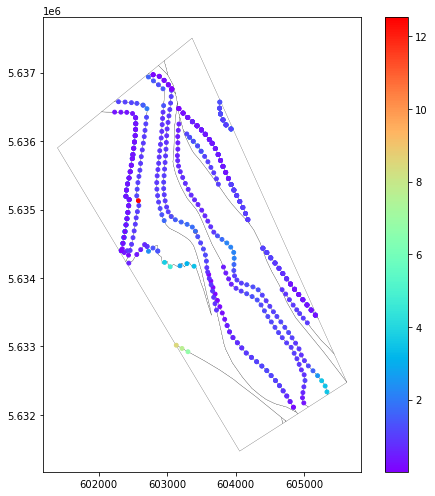

In [73]:
if(workflow['formation_thickness']):

    geology_file=tmp_path+'basal_contacts.shp'
    contact_decimate=5
    null_scheme='null'
    m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],bbox,c_l,null_scheme,contact_decimate)
    
    buffer =5000
    max_thickness_allowed=10000

    m2l_geometry.calc_thickness_with_grid(tmp_path,output_path,buffer,max_thickness_allowed,
                                          c_l,bbox,dip_grid,dip_dir_grid,x,y,spacing)
    
    m2l_geometry.calc_min_thickness_with_grid(tmp_path,output_path,buffer,max_thickness_allowed,
                                          c_l,bbox,dip_grid,dip_dir_grid,x,y,spacing)
    m2l_geometry.normalise_thickness(output_path)
    
    m2l_utils.plot_points(output_path+'formation_thicknesses_norm.csv',geol_clip,'norm_th','x','y',True,'numeric')


## Creates fold axial trace points

In [77]:
from shapely import geometry
from shapely.geometry import shape, Polygon, LineString, Point, MultiLineString, MultiPolygon
import matplotlib.pyplot as plt
import requests
import rasterio
from pandas import DataFrame
from geopandas import GeoDataFrame
import geopandas as gpd
import pandas as pd
from math import acos, sqrt, cos, sin, degrees, radians, fabs, atan2, fmod, isnan
from map2loop import m2l_utils
from map2loop import m2l_interpolation
import numpy as np
import os
import random

def save_fold_axial_traces(path_folds,path_fold_orientations,dtm,dtb,dtb_null,cover_map,c_l,fold_decimate):
    folds_clip=gpd.read_file(path_folds)
    fo=open(path_fold_orientations+'/fold_axial_traces.csv',"w")
    fo.write("X,Y,Z,code,type\n")

    for indx,fold in folds_clip.iterrows():
        fold_name=str(fold[c_l['o']])
        if(not str(fold.geometry) =='None'):
            if(fold.geometry.type=='MultiLineString'):
                for mls in fold.geometry:
                    fold_ls=LineString(mls)

                    i=0
                    for afs in fold_ls.coords:
                        if(c_l['fold'] in fold[c_l['ff']]):
                            if(m2l_utils.mod_safe(i,fold_decimate)==0 or i==int((len(fold_ls.coords)-1)/2) or i==len(fold_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape
                                locations=[(afs[0],afs[1])]     
                                height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                ostr="{},{},{},FA_{},{}\n"\
                                     .format(afs[0],afs[1],height,fold_name,fold[c_l['t']].replace(',',''))
                                #ostr=str(afs[0])+','+str(afs[1])+','+str(height)+','+'FA_'+fold_name+','+fold[c_l['t']].replace(',','')+'\n'
                                fo.write(ostr)                
                        i=i+1  
            else:
                fold_ls=LineString(fold.geometry)

                i=0
                for afs in fold_ls.coords:
                    if(c_l['fold'] in fold[c_l['ff']]):
                        if(m2l_utils.mod_safe(i,fold_decimate)==0 or i==int((len(fold_ls.coords)-1)/2) or i==len(fold_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape
                            locations=[(afs[0],afs[1])]     
                            height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                            ostr="{},{},{},FA_{},{}\n"\
                                  .format(afs[0],afs[1],height,fold_name,fold[c_l['t']].replace(',',''))
                            #ostr=str(afs[0])+','+str(afs[1])+','+str(height)+','+'FA_'+fold_name+','+fold[c_l['t']].replace(',','')+'\n'
                            fo.write(ostr)                
                    i=i+1  

    fo.close()
    print("fold axial traces saved as",path_fold_orientations+'fold_axial_traces.csv')
def save_fold_axial_traces_orientations(path_folds,output_path,tmp_path,dtm,dtb,dtb_null,cover_map,c_l,dst_crs,fold_decimate,fat_step,close_dip,scheme,bbox,spacing,dip_grid,dip_dir_grid):
    geology = gpd.read_file(tmp_path+'geol_clip.shp')
    #contacts=np.genfromtxt(tmp_path+'interpolation_contacts_'+scheme+'.csv',delimiter=',',dtype='float')
    f=open(output_path+'fold_axial_trace_orientations2.csv','w')
    f.write('X,Y,Z,azimuth,dip,polarity,formation,group\n')
    folds_clip=gpd.read_file(path_folds,)
    fo=open(output_path+'fold_axial_traces.csv',"w")
    fo.write("X,Y,Z,code,type\n")
    dummy=[]
    dummy.append(1)
    for indx,fold in folds_clip.iterrows():
        fold_name=str(fold[c_l['o']])   
        if(not str(fold.geometry) =='None'):
            if(fold.geometry.type=='MultiLineString'):
                for mls in fold.geometry:              
                    fold_ls=LineString(mls)        

                    i=0
                    first=True
                    for afs in fold_ls.coords:
                        if(c_l['fold'] in fold[c_l['ff']]):
                            # save out current geometry of FAT
                            if(m2l_utils.mod_safe(i,fold_decimate)==0 or i==int((len(fold_ls.coords)-1)/2) or i==len(fold_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape
                                locations=[(afs[0],afs[1])]                  
                                height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                ostr="{},{},{},FA_{},{}\n"\
                                      .format(afs[0],afs[1],height,fold_name,fold[c_l['t']].replace(',',''))
                                #ostr=str(afs[0])+','+str(afs[1])+','+str(height)+','+'FA_'+fold_name+','+fold[c_l['t']].replace(',','')+'\n'
                                fo.write(ostr)  
                                # calculate FAT normal offsets  
                                if(not first):
                                    l,m=m2l_utils.pts2dircos(lastx,lasty,afs[0],afs[1])
                                    midx=lastx+((afs[0]-lastx)/2)
                                    midy=lasty+((afs[1]-lasty)/2)
                                    midxr=midx+(fat_step*-m)
                                    midyr=midy+(fat_step*l)
                                    midxl=midx-(fat_step*-m)
                                    midyl=midy-(fat_step*l)
                                    r=int((midy-bbox[1])/spacing)
                                    c=int((midx-bbox[0])/spacing)
                                    if(close_dip==-999):
                                        dip=dip_grid[r,c]
                                    else:
                                        dip=close_dip
                                    dip_dir=dip_dir_grid[r,c]

                                    dip2,dipdir2=m2l_utils.dircos2ddd(-m,l,cos(radians(dip)))
                                    if(c_l['syn'] in fold[c_l['t']]):
                                        dipdir2=dipdir2+180

                                    lc=sin(radians(dip_dir-90))
                                    mc=cos(radians(dip_dir-90))
                                    dotprod=fabs((l*lc)+(m*mc))
                                    #print(dotprod,midx,midy,minind,contacts[minind,2],l,m,lc,mc)   
                                    # if FAT is sub-parallel to local interpolated contacts, save out as orientations  
                                    if(dotprod>0.85):
                                        geometry = [Point(midxr,midyr)]
                                        gdf = GeoDataFrame(dummy, crs=dst_crs, geometry=geometry)
                                        structure_code = gpd.sjoin(gdf, geology, how="left", op="within")
                                        if(not str(structure_code.iloc[0][c_l['c']])=='nan'):
                                            locations=[(midxr,midyr)]                  
                                            height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                            ostr="{},{},{},{},{},{},{},{}\n"\
                                                  .format(midxr,midyr,height,dipdir2,int(dip),1,str(structure_code.iloc[0][c_l['c']]).replace(" ","_").replace("-","_"),structure_code.iloc[0][c_l['g']])
                                            #ostr=str(midxr)+','+str(midyr)+','+str(height)+','+str(dipdir)+','+str(int(dip))+',1,'+str(structure_code.iloc[0][c_l['c']]).replace(" ","_").replace("-","_")+','+str(structure_code.iloc[0][c_l['g']])+'\n'
                                            f.write(ostr)

                                        geometry = [Point(midxl,midyl)]
                                        gdf = GeoDataFrame(dummy, crs=dst_crs, geometry=geometry)
                                        structure_code = gpd.sjoin(gdf, geology, how="left", op="within")
                                        if(not str(structure_code.iloc[0][c_l['c']])=='nan'):
                                            locations=[(midxl,midyl)]                  
                                            height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                            ostr="{},{},{},{},{},{},{},{}\n"\
                                                  .format(midxl,midyl,height,dipdir2+180,int(dip),1,str(structure_code.iloc[0][c_l['c']]).replace(" ","_").replace("-","_"),structure_code.iloc[0][c_l['g']])
                                            #ostr=str(midxl)+','+str(midyl)+','+str(height)+','+str(dipdir+180)+','+str(int(dip))+',1,'+str(structure_code.iloc[0][c_l['c']]).replace(" ","_").replace("-","_")+','+str(structure_code.iloc[0][c_l['g']])+'\n'
                                            f.write(ostr)
                                first=False
                                lastx=afs[0]
                                lasty=afs[1]
                        i=i+1  
            else:
                fold_ls=LineString(fold.geometry)
                i=0
                first=True
                for afs in fold_ls.coords:
                    if(c_l['fold'] in fold[c_l['ff']]):
                        # save out current geometry of FAT
                        if(m2l_utils.mod_safe(i,fold_decimate)==0 or i==int((len(fold_ls.coords)-1)/2) or i==len(fold_ls.coords)-1): #decimate to reduce number of points, but also take mid and end points of a series to keep some shape
                            locations=[(afs[0],afs[1])]                  
                            height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                            ostr="{},{},{},FA_{},{}\n"\
                                  .format(afs[0],afs[1],height,fold_name,fold[c_l['t']].replace(',',''))
                            #ostr=str(afs[0])+','+str(afs[1])+','+str(height)+','+'FA_'+fold_name+','+fold[c_l['t']].replace(',','')+'\n'
                            fo.write(ostr)  
                            # calculate FAT normal offsets  
                            if(not first):
                                l,m=m2l_utils.pts2dircos(lastx,lasty,afs[0],afs[1])
                                midx=lastx+((afs[0]-lastx)/2)
                                midy=lasty+((afs[1]-lasty)/2)
                                midxr=midx+(fat_step*-m)
                                midyr=midy+(fat_step*l)
                                midxl=midx-(fat_step*-m)
                                midyl=midy-(fat_step*l)
                                r=int((midy-bbox[1])/spacing)
                                c=int((midx-bbox[0])/spacing)
                                if(close_dip==-999):
                                    dip=dip_grid[r,c]
                                else:
                                    dip=close_dip
                                dipdir=dip_dir_grid[r,c]
                                dip2,dipdir2=m2l_utils.dircos2ddd(-m,l,cos(radians(dip)))
                                if(c_l['syn'] in fold[c_l['t']]):
                                    dipdir2=dipdir2+180
                                lc=sin(radians(dipdir-90))
                                mc=cos(radians(dipdir-90))
                                dotprod=fabs((l*lc)+(m*mc))
                                #print(dotprod,midx,midy,minind,contacts[minind,2],l,m,lc,mc)   
                                # if FAT is sub-parallel to local interpolated contacts, save out as orientations  
                                if(dotprod>0.85):
                                    geometry = [Point(midxr,midyr)]
                                    gdf = GeoDataFrame(dummy, crs=dst_crs, geometry=geometry)
                                    structure_code = gpd.sjoin(gdf, geology, how="left", op="within")
                                    if(not str(structure_code.iloc[0][c_l['c']])=='nan'):
                                        locations=[(midxr,midyr)]                  
                                        height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                        ostr="{},{},{},{},{},{},{},{}\n"\
                                              .format(midxr,midyr,height,dipdir2,int(dip),1,str(structure_code.iloc[0][c_l['c']]).replace(" ","_").replace("-","_"),structure_code.iloc[0][c_l['g']])
                                        #ostr=str(midxr)+','+str(midyr)+','+str(height)+','+str(dipdir)+','+str(int(dip))+',1,'+str(structure_code.iloc[0][c_l['c']]).replace(" ","_").replace("-","_")+','+str(structure_code.iloc[0][c_l['g']])+'\n'
                                        f.write(ostr)

                                    geometry = [Point(midxl,midyl)]
                                    gdf = GeoDataFrame(dummy, crs=dst_crs, geometry=geometry)
                                    structure_code = gpd.sjoin(gdf, geology, how="left", op="within")
                                    if(not str(structure_code.iloc[0][c_l['c']])=='nan'):
                                        locations=[(midxl,midyl)]                  
                                        height=m2l_utils.value_from_dtm_dtb(dtm,dtb,dtb_null,cover_map,locations)
                                        ostr="{},{},{},{},{},{},{},{}\n"\
                                              .format(midxl,midyl,height,dipdir2+180,int(dip),1,str(structure_code.iloc[0][c_l['c']]).replace(" ","_").replace("-","_"),structure_code.iloc[0][c_l['g']])
                                        #ostr=str(midxl)+','+str(midyl)+','+str(height)+','+str(dipdir+180)+','+str(int(dip))+',1,'+str(structure_code.iloc[0][c_l['c']]).replace(" ","_").replace("-","_")+','+str(structure_code.iloc[0][c_l['g']])+'\n'
                                        f.write(ostr)
                            first=False
                            lastx=afs[0]
                            lasty=afs[1]
                    i=i+1  
    
    fo.close()
    f.close()
    print("fold axial traces saved as",output_path+'fold_axial_traces.csv')
    print("fold axial trace orientations saved as",output_path+'fold_axial_trace_orientations.csv')
    
if(workflow['fold_axial_traces']   and  os.path.exists(fold_file)):
    folds_clip = gpd.read_file(fold_file)
    if(len(folds_clip)>0):
        
        #m2l_geometry.save_fold_axial_traces(fold_file,output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fold_decimate)
        save_fold_axial_traces(fold_file,output_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,fold_decimate)

        #Save fold axial trace near-hinge orientations
        fat_step=750         # how much to step out normal to fold axial trace
        close_dip=-999       #dip to assign to all new orientations (-999= use local interpolated dip)

#        m2l_geometry.save_fold_axial_traces_orientations(fold_file,output_path,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,
#                                                         fold_decimate,fat_step,close_dip,scheme,bbox,spacing,dip_grid,dip_dir_grid)
        save_fold_axial_traces_orientations(fold_file,output_path,tmp_path,dtm,dtb,dtb_null,workflow['cover_map'],c_l,dst_crs,
                                                         fold_decimate,fat_step,close_dip,scheme,bbox,spacing,dip_grid,dip_dir_grid)


fold axial traces saved as ../Rockies/output/fold_axial_traces.csv
fold axial traces saved as ../Rockies/output/fold_axial_traces.csv
fold axial trace orientations saved as ../Rockies/output/fold_axial_trace_orientations.csv


## Preprocess data to ensure it meets modelling requirements

In [78]:
m2l_geometry.tidy_data(output_path,tmp_path,clut_path,use_gcode3,use_interpolations,use_fat,pluton_form,inputs,workflow,c_l)
dtm.close()
if(workflow['cover_map']):
    dtb.close()

No invented orientations available for merging.
Guessing formation thickness of DvCb_EBf_l_lm as 287.0


## Calculate polarity of original bedding orientation data (not used yet in final calc)

In [79]:
if(workflow['polarity']):
    m2l_geometry.save_orientations_with_polarity(output_path+'orientations.csv',output_path,c_l,tmp_path+'basal_contacts.shp',tmp_path+'all_sorts.csv',)

    m2l_utils.plot_points(output_path+'orientations_polarity.csv',geol_clip,'polarity','X','Y',True,'alpha')


## Calculate minimum fault offset from stratigraphy and stratigraphic fault offset

In [80]:
if(workflow['strat_offset'] and os.path.exists(fault_file)):
    fault_test=pd.read_csv(output_path+'fault_dimensions.csv',',')
    if(len(fault_test)>0):

        m2l_geometry.fault_strat_offset(output_path,c_l,dst_crs,output_path+'formation_summary_thicknesses.csv', tmp_path+'all_sorts.csv',tmp_path+'faults_clip.shp',tmp_path+'geol_clip.shp',output_path+'fault_dimensions.csv')


        m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'min_offset','X','Y',True,'numeric')
        m2l_utils.plot_points(output_path+'fault_strat_offset3.csv',geol_clip,'strat_offset','X','Y',True,'numeric')

## Analyse fault-fault topology

cycles []


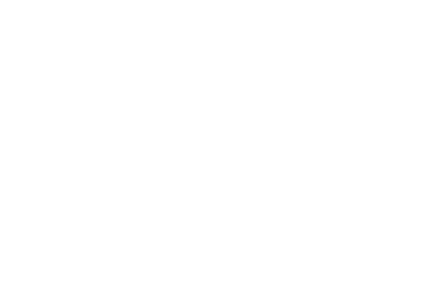

In [81]:
if(os.path.exists(fault_file)):
    m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gemodeller test 



In [82]:
if(workflow['model_engine']=='geomodeller'):
    from datetime import datetime
    import shutil

    
    m2l_topology.check_near_fault_contacts(tmp_path+'faults_clip.shp',tmp_path+'all_sorts_clean.csv',
                                           output_path+'fault_dimensions.csv',output_path+'group-fault-relationships.csv',
                                           output_path+'contacts_clean.csv',c_l,dst_crs)

    nowtime=datetime.now().isoformat(timespec='minutes')   
    model_name=test_data_name+'_'+nowtime.replace(":","-").replace("T","-")
    os.mkdir(test_data_path+'/'+model_name)
    save_faults=True
    compute_etc=True
    t1 = time.time()
    m2l_export.loop2geomodeller(model_name,test_data_path,tmp_path,output_path,'../dtm/dtm_rp.tif',bbox,
                                model_top,model_base,save_faults,compute_etc,workflow)
    t2 = time.time()
    os.chdir(test_data_path+'/'+model_name)
    %system geomodellerbatch.exe -batch m2l.taskfile
    t3 = time.time()
    #%system geomodellerbatch.exe -batch m2l_compute.taskfile
    t4 = time.time()
    print("m2l",(t1-t0)/60.0,"export process",(t2-t1)/60.0,"batch process",(t3-t2)/60.0,"batch calculate",(t4-t3)/60.0,"minutes")
    #shutil.copy('../tmp','.')
    #shutil.copy('../output','.')
    #shutil.copy('../graph','.')
    #shutil.copy('../dtm','.')
    os.chdir('..')

In [83]:
data_path='D:/Loop_Data/GSC/3D_Rockies/'
gsc_out_path=data_path+'m2l/'
faults=pd.read_csv(output_path+'faults.csv',',')
contacts=pd.read_csv(output_path+'contacts_clean.csv',',')
#display(contacts,faults)   
for sec_no in range(1,11):
    section_contacts_path=gsc_out_path+'basal_contacts_{}.csv'.format(sec_no)    
    section_contacts=pd.read_csv(section_contacts_path,',')
    contacts=pd.concat([contacts,section_contacts],sort=False)
    
    section_faults_path=gsc_out_path+'fault_{}.csv'.format(sec_no)
    section_faults=pd.read_csv(section_faults_path,',')
    section_faults=section_faults[~section_faults['formation'].str.contains('None')]
    faults=pd.concat([faults,section_faults],sort=False)


contacts.index = range(len(contacts.index))
faults.index = range(len(faults.index))
contacts.to_csv(output_path+'contacts_clean.csv',index_label='index')
faults.to_csv(output_path+'faults.csv',index=False)

# loopstructural test

In [84]:
if(workflow['model_engine']=='loopstructural'):
    #model_base=-8200

    import random
    
    from LoopStructural import GeologicalModel
    import lavavu
    from LoopStructural.visualisation import LavaVuModelViewer
    from LoopStructural import GeologicalModel
    import logging
    logging.getLogger().setLevel(logging.ERROR)

    f=open(tmp_path+'bbox.csv','w')
    f.write('minx,miny,maxx,maxy,lower,upper\n')
    ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
    f.write(ostr)
    f.close()
    t1 = time.time()
    fault_params = {'interpolatortype':'FDI',
                    'nelements':3e4,
                    'data_region':.1,
                    'solver':'pyamg',
    #                 overprints:overprints,
                    'cpw':10,
                    'npw':10}
    foliation_params = {'interpolatortype':'PLI' , # 'interpolatortype':'PLI',
                        'nelements':1e5,  # how many tetras/voxels
                        'buffer':0.8,  # how much to extend nterpolation around box
                        'solver':'pyamg',
                        'damp':True}
    if(not os.path.exists(fault_file)):
        f=open(output_path + '/fault_displacements3.csv','w')
        f.write('X,Y,fname,apparent_displacement,vertical_displacement,downthrow_dir\n')
        f.close()
        f=open(output_path + '/fault_orientations.csv','w')
        f.write('X,Y,Z,DipDirection,dip,DipPolarity,formation\n')
        f.close()
        f=open(output_path + '/faults.csv','w')
        f.write('X,Y,Z,formation\n')
        f.close()
        f=open(output_path + '/fault-fault-relationships.csv','w')
        f.write('fault_id\n')
        f.close()
        f=open(output_path + '/group-fault-relationships.csv','w')
        f.write('group\n')
        f.close()

        model, m2l_data = GeologicalModel.from_map2loop_directory(test_data_path,
                                                              skip_faults=True,
                                                              fault_params=fault_params,
                                                              foliation_params=foliation_params)
    else:
        model, m2l_data = GeologicalModel.from_map2loop_directory(test_data_path,
                                                              skip_faults=False,
                                                              fault_params=fault_params,
                                                              foliation_params=foliation_params)
  
    view = LavaVuModelViewer(model,vertical_exaggeration=2) 
    view.nsteps = np.array([200,200,200])
    #view.set_zscale(2)
    for sg in model.feature_name_index:
        if( 'super' in sg ):
            view.add_data(model.features[model.feature_name_index[sg]])
    view.add_model(cmap='tab20')
    view.nsteps=np.array([50,50,50])
    view.add_model_surfaces()
    view.interactive()  
    

    t2 = time.time()
    print("m2l",(t1-t0)/60.0,"LoopStructural",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")

ValueError: setting an array element with a sequence.

## Overlay map over model

In [ ]:
import matplotlib.colors as colors
clut_path =''
if(clut_path ==''):
    geol_clip.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
    use_cmap=True
    cmap = m2l_export.rand_cmap(100, type='soft', first_color_black=False, last_color_black=False, verbose=False)
elif(workflow['model_engine']=='loopstructural'):
    use_cmap=True
    asc=pd.read_csv(tmp_path+'all_sorts_clean.csv',",")
    #display(asc)
    colours=pd.read_csv(clut_path,",")
    if( c_l['c']=='CODE'):
        code=c_l['c'].lower()
    else:
        code=c_l['c']

    colours = [] #container for the discrete colours we are using
    i=0
    geol_clip['colour_index'] = np.nan #initialise a colour index attribute column
    for ind,strat in asc.iterrows():
        geol_clip[c_l['c']].str.replace(" ","_")
        geol_clip.loc[geol_clip[c_l['c']]==strat['code'].replace("_"," "),'colour_index'] = i
        colours.append(strat['colour'])
        i=i+1
    
    cmap = colors.ListedColormap(colours) # create a cmap for passing to geopandas
    #display(colours)
    fig, ax = matplotlib.pyplot.subplots(figsize=(15, 15))
    geol_clip.plot(ax=ax,column='colour_index',figsize=(10,10),edgecolor='#000000',linewidth=0.2,cmap=cmap)
if(workflow['model_engine']=='loopstructural'):  
    dtm = rasterio.open(dtm_reproj_file)
    if(os.path.exists(fault_file)):
        f_clip=faults_clip[faults_clip[c_l['f']].str.contains(c_l['fault'])]
        m2l_export.display_LS_map(model,dtm,geol_clip,f_clip,dst_crs,use_cmap,cmap,use_topo=True,use_faults=True)
    else:
        f_clip=[]
        m2l_export.display_LS_map(model,dtm,geol_clip,f_clip,dst_crs,use_cmap,cmap,use_topo=True,use_faults=False)

    dtm.close()


## Save out voxel model

In [ ]:
if(workflow['model_engine']=='loopstructural'):  
    voxel_size=500
    sizex=int((maxx-minx)/voxel_size)
    sizey=int((maxy-miny)/voxel_size)
    sizez=int((model_top-model_base)/voxel_size)
    print('voxel_size=',voxel_size,', saved in Z,Y,X order, Z=',sizez,', Y=',sizey,', X=',sizex)
    print('lower south west corner: west=',minx,', south=',miny,', lower=',model_base)
    voxels=model.evaluate_model(model.regular_grid(nsteps=(sizey,sizex,sizez),shuffle=False))
    np.savetxt(tmp_path+'voxels.raw', voxels, fmt='%d',delimiter='\t',newline='')
    print('voxels saved as',tmp_path+'voxels.raw')
    print("ImageJ ordering Width=",sizez,', Height=',sizex,', Number of Images=',sizey)

# gempy test

In [ ]:
if(workflow['model_engine']=='gempy'):

    t1 = time.time()
    import importlib
    importlib.reload(m2l_export)


    vtk = True
    if  vtk:
        vtkexp = gp._plot.export_to_vtk(geo_model, path=vtk_path, name=test_data_name + '.vtk', voxels=False, block=None,
        surfaces=True)
    else:
        m2l_export.loop2gempy(test_data_name,tmp_path,vtk_path,output_path+'orientations_clean.csv',
                                output_path+'contacts_clean.csv',tmp_path+'groups_clean.csv',
                                bbox,model_base, model_top,vtk,dtm_reproj_file)


# noddy test

In [ ]:
if(workflow['model_engine']=='noddy'):

    import pynoddy.history
    import networkx as nx
    #Read a csv file with the vertices of the faults
    #see notes in the bottom of the notebook for instructions on how to generate such vertices files
    t1 = time.time()
    
    scale=1.5 #  scales mdoel to fit predefined volume (complete hack)
    
    # load fault coordinates
    faultsxy=pd.read_csv(output_path+'faults.csv')

    #load fault graph, remove cyclic loops and find (non-unique) age-ordered list 
    G=nx.read_gml(tmp_path+"fault_network.gml")
    cycles=list(nx.simple_cycles(G))
    for c in cycles:
        G.remove_edge(c[0], c[1])
    faults=nx.topological_sort(G)

    # write out Noe format format file
    file=open(tmp_path+'faults_for_noe.csv','w')
    file.write('id,DipDirecti,X,Y\n')
    for f in faults:
            fxy=faultsxy[faultsxy["formation"]==f.replace("\n","")]
            #display(f.replace("\n",""))
            for ind,xy in fxy.iterrows():
                ostr=f.replace('\n','')+',West,'+str(xy['X']/scale)+','+str(xy['Y']/scale)+'\n'
                file.write(ostr)
    file.close()
    
    csvfile = tmp_path+'faults_for_noe.csv'
    CsvFaultData = pd.read_csv(csvfile)

    #how much does the fault slip relative to the fault length
    SlipParam = 0.1

    #the xyz origin of the model you will be generating
    xy_origin=[minx/scale,miny/scale, 1200-4000]

    #Get information about each parameter in Noddy format
    #The output from the function is a dictionary with lists of the fault parameters
    noddyFormattedFaultData =  pynoddy.history.setUpFaultRepresentation(CsvFaultData,
                                                        xy_origin=xy_origin, 
                                                        SlipParam=SlipParam)

    #Create a dictionary with the stratigraphy information
    StratDict = {}
    StratDict['Heights'] = [2000, 2500, 3000, 3700]
    StratDict['Names'] = ['Intrusive', 'Felsic', 'Mafic','Sed'] 
    StratDict['Density'] =  [2.65, 2.5, 2.4, 2.3] 
    StratDict['MagSus'] = [0.0015, 0.0012, 0.0018, 0.001]

    #Now make the history file
    filename = output_path+'faultmodel.his'
    noddyFormattedFaultData =  pynoddy.history.createPyNoddyHistoryFile(noddyFormattedFaultData, StratDict, filename=filename)


In [ ]:
if(workflow['model_engine']=='noddy'):
    import vtkplotter as vtkP
    import itkwidgets
    import k3d
    import pynoddy.output
    import pynoddy.history

    modelfile = output_path+'faultmodel.his'

    # Determine the path to the noddy executable
    noddy_path = '../../pynoddy-new/noddyapp/noddy_win64.exe'

    # Where you would like to place all your output files
    outputfolder = tmp_path

    # choose what software to use for visualizing the model
    #you can also choose to change to itkwidgets, k3d, False (popup), or panel
    #you might need to install packages depending on what you choose
    vtkP.settings.embedWindow('k3d') 

    # create a plot in vtkplotter
    plot = vtkP.Plotter(axes=1, bg='white', interactive=1)

    # call the plotting function
    points = pynoddy.output.CalculatePlotStructure(modelfile, plot, noddy_path, 
                                           outputfolder=outputfolder,
                                           LithologyOpacity=0.2, outputOption=0)
    plot.show(viewup='z')
    t2 = time.time()

    print("m2l",(t1-t0)/60.0,"noddy",(t2-t1)/60.0,"Total",(t2-t0)/60.0,"minutes")
